# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy as sc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
from imblearn.pipeline import Pipeline as iPipline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt', header = None)
labels.columns = ['label']

In [3]:
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [4]:
int_cols = [col for col in data.columns if data[col].dtype == 'int64']
float_cols = [col for col in data.columns if data[col].dtype == 'float64']
object_cols = [col for col in data.columns if data[col].dtype == 'object']

2\. Рассчитайте доли классов `отток` и `не отток`.

In [5]:
print('Доля пользователей не отток {}'.format(labels['label'].value_counts(normalize = True)[-1]))
print('Доля пользователей отток {}'.format(labels['label'].value_counts(normalize = True)[1]))

Доля пользователей не отток 0.9256
Доля пользователей отток 0.0744


3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

In [6]:
corr_params = pd.concat([data.loc[:, int_cols+float_cols], labels], axis=1)

In [7]:
corr_table = corr_params.corr()

Крреляция Пирсона вещественных признаков с целевой переменной представлена ниже

In [8]:
labels_corr = pd.DataFrame(corr_table.iloc[:, -1])
labels_corr.drop(index='label', inplace=True)
labels_corr

,label
Var73,-0.069550
Var1,0.011484
Var2,-0.006502
Var3,-0.007428
Var4,0.002343
...,...
Var188,0.095238
Var189,-0.122501
Var190,-0.041449
Var209,NaN


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [9]:
labels_corr['abs_correlation'] = np.abs(labels_corr)

In [10]:
na_corr_features = labels_corr[labels_corr.abs_correlation.isna()].index

In [11]:
labels_corr.sort_values(by='abs_correlation', ascending=False, inplace = True)

In [12]:
high_corr_var = labels_corr['label'].iloc[:20].index

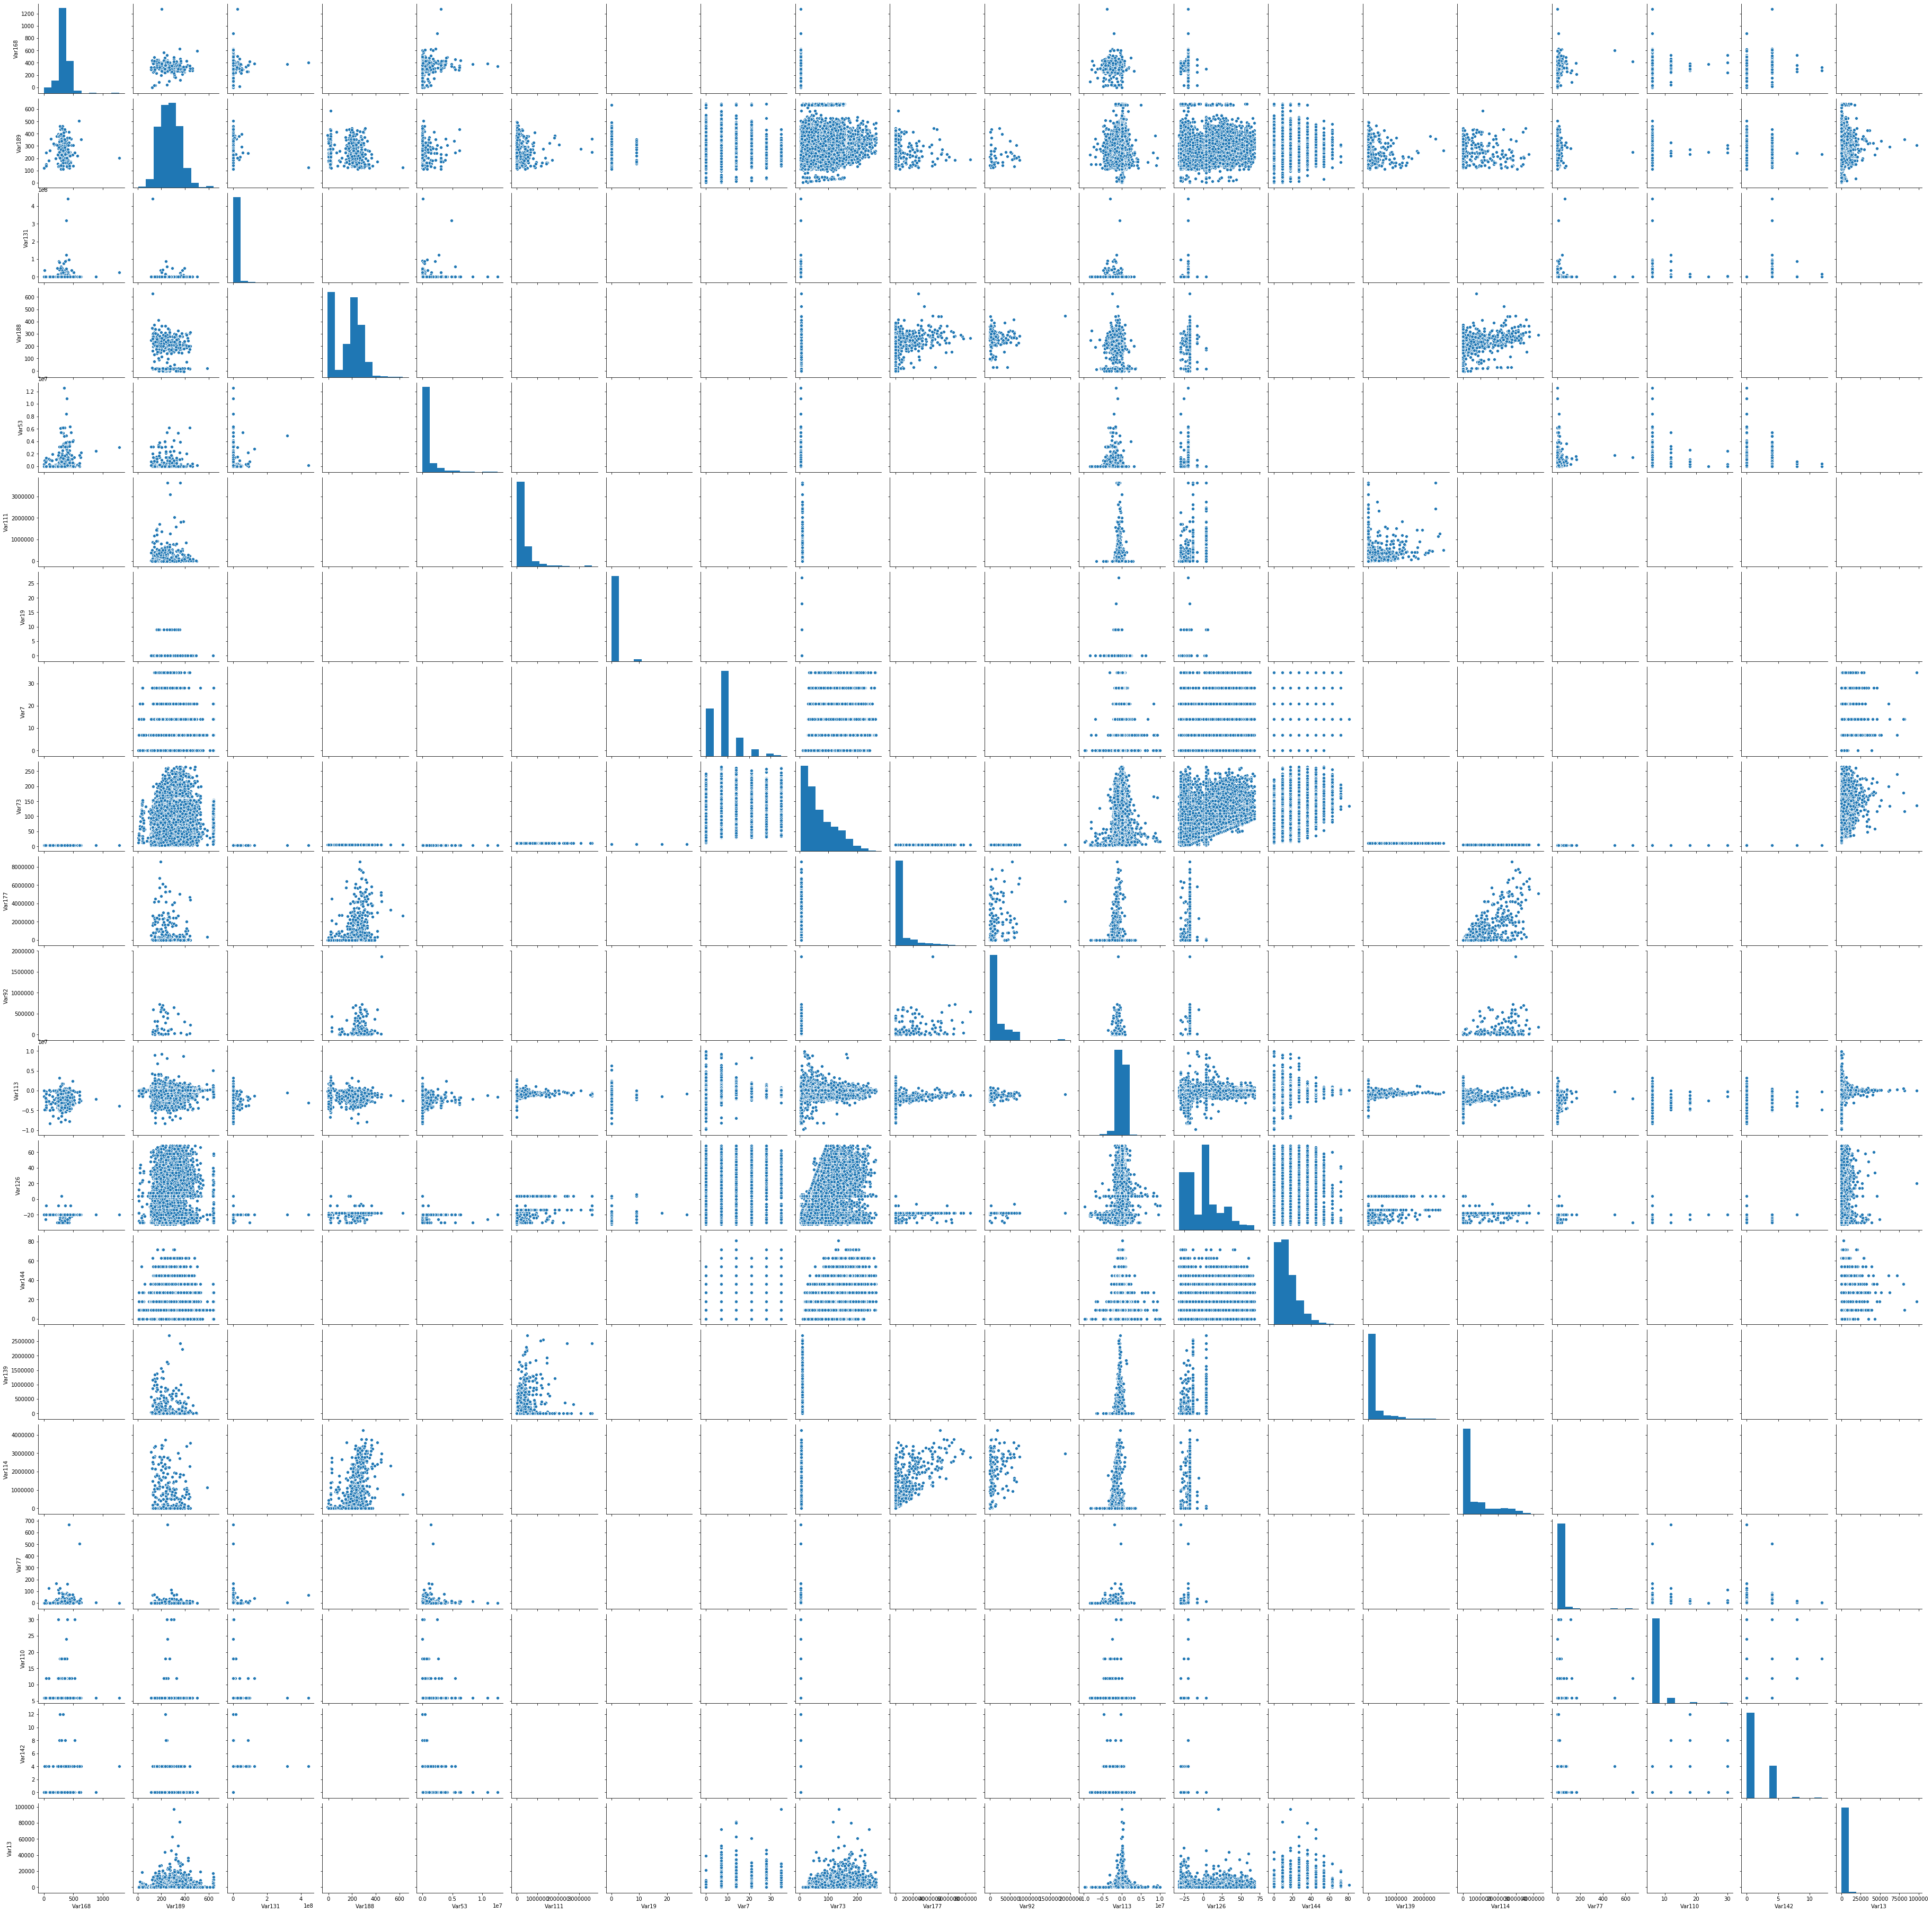

In [13]:
sns.pairplot(data[high_corr_var.to_list()])

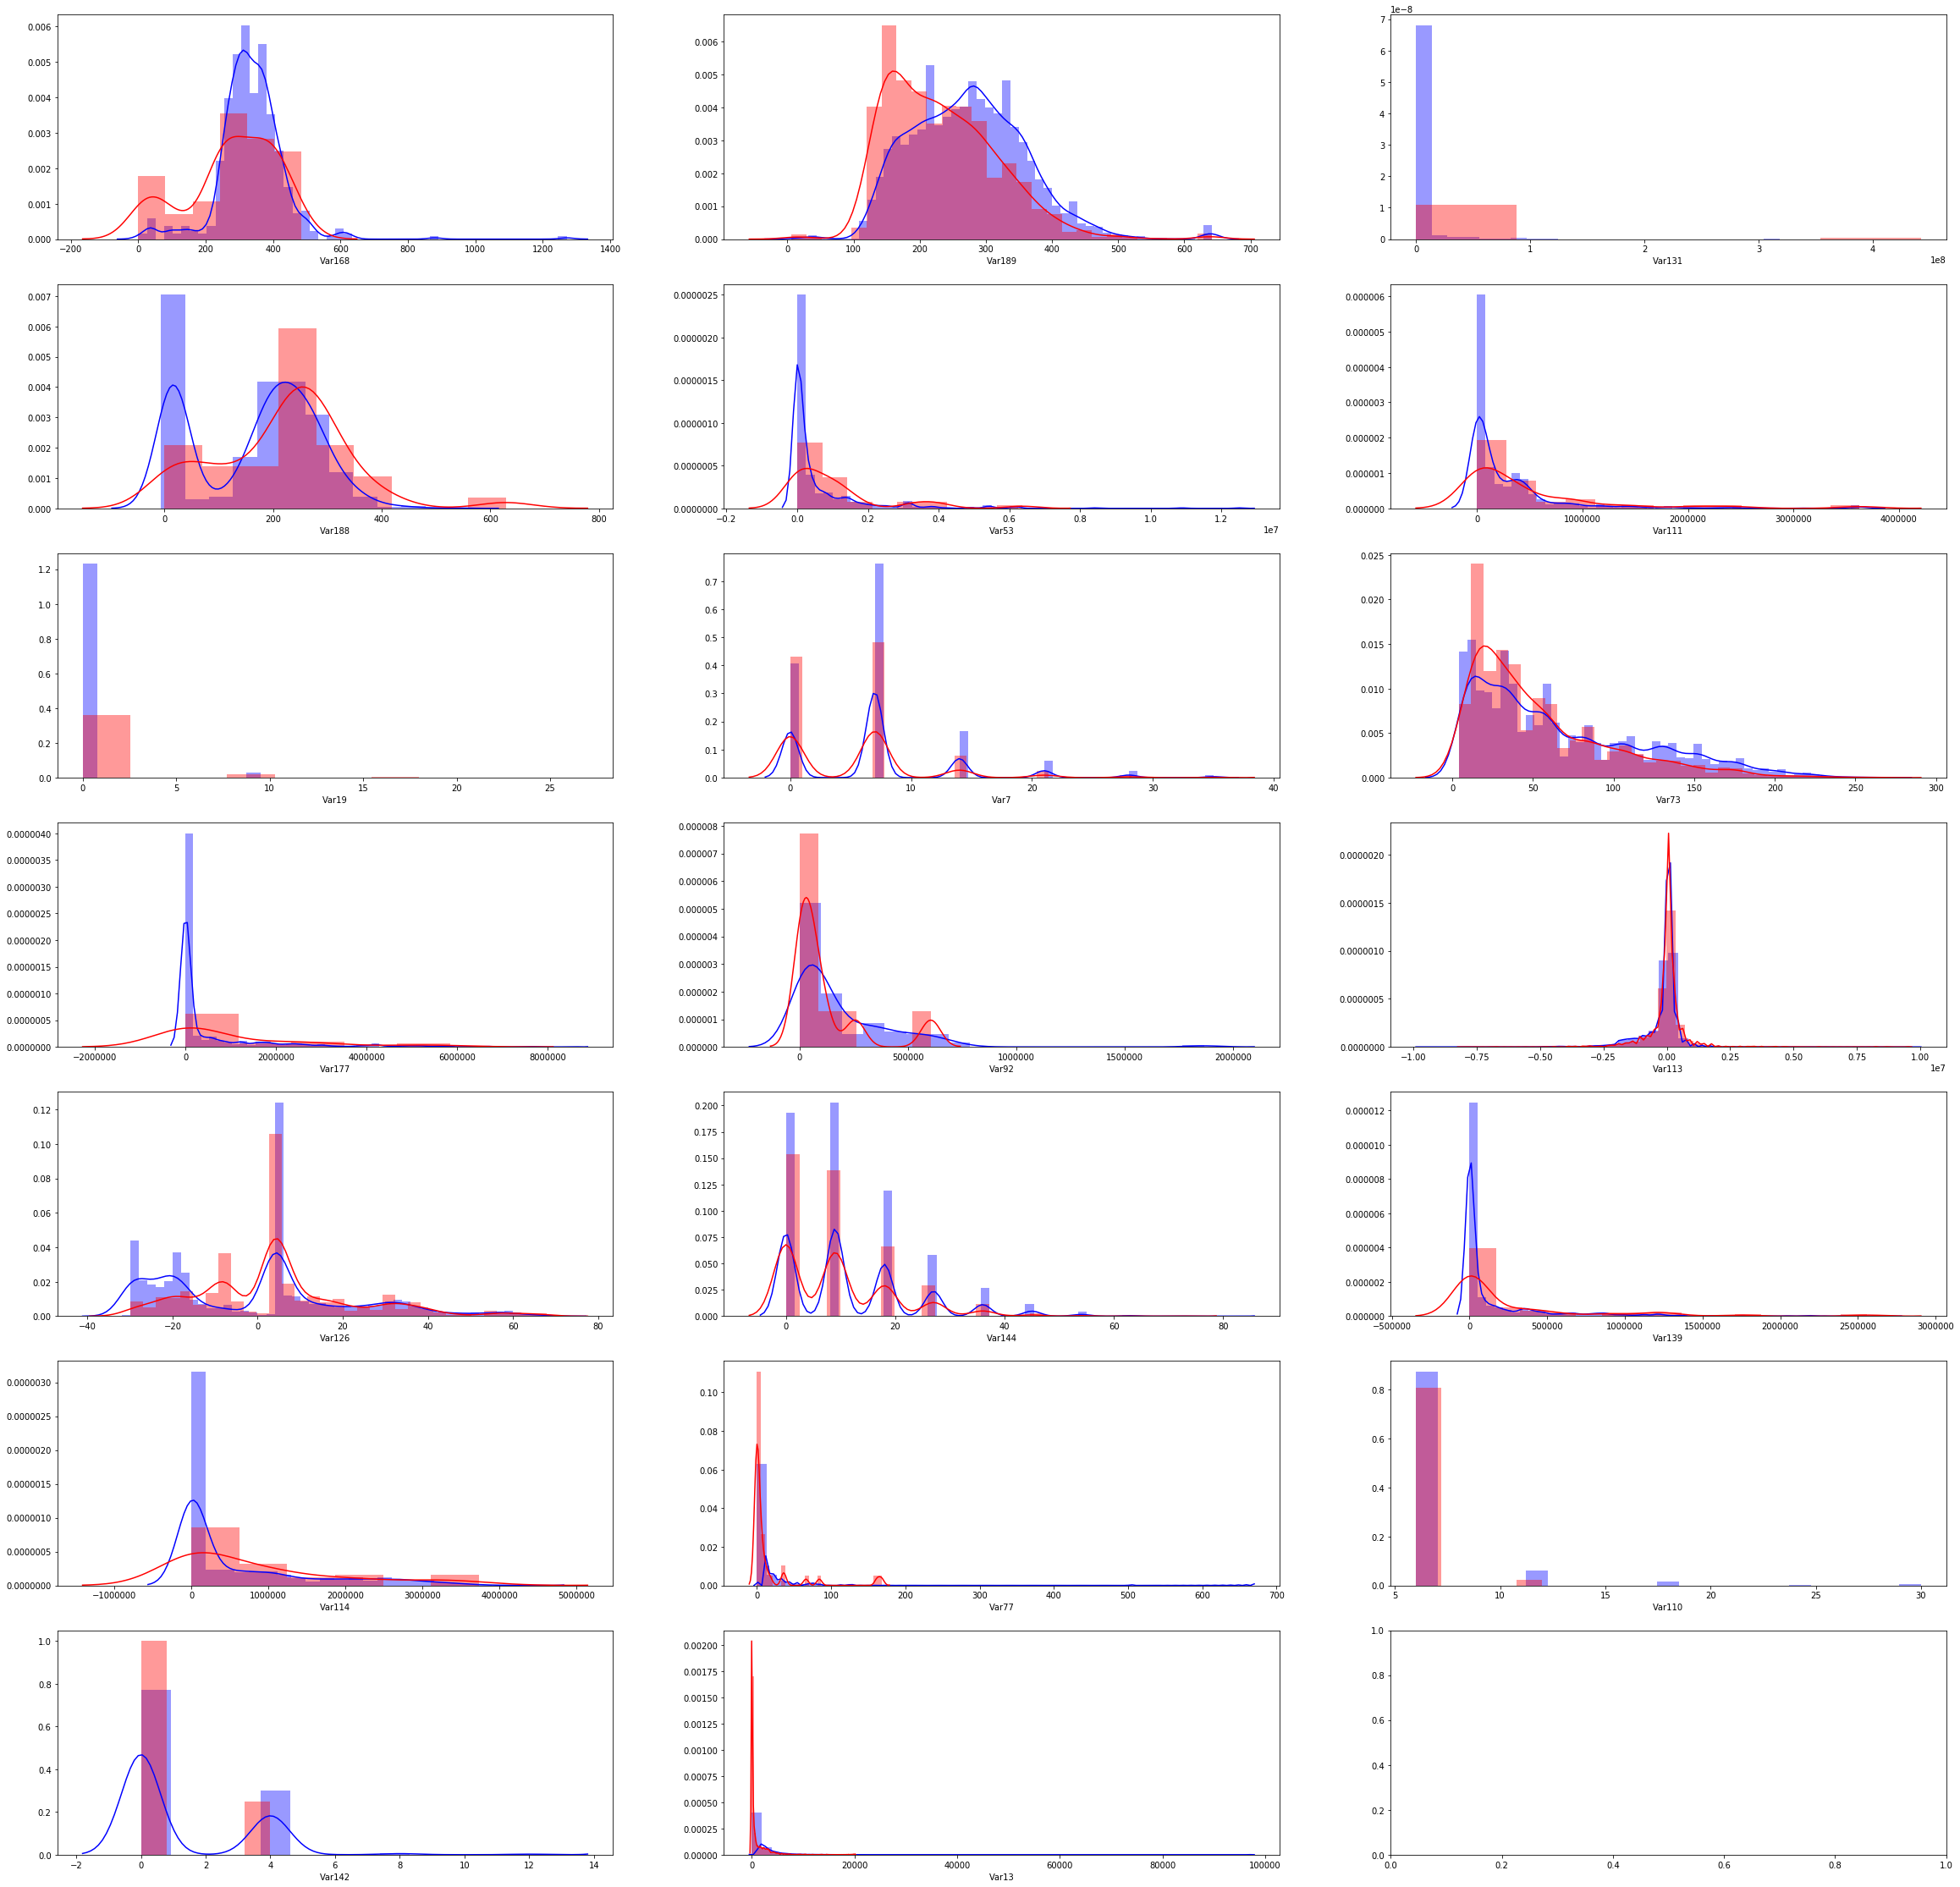

In [14]:
fig, axes = plt.subplots(int(len(high_corr_var)/3)+1, 3, figsize=(40, 40), sharey=False)
for i, var in enumerate(high_corr_var):
    sns.distplot(corr_params[corr_params.label == -1].loc[:, var], color='b', ax=axes[int(i / 3), i % 3], label='-1')
    sns.distplot(corr_params[corr_params.label == 1].loc[:, var], color='r', ax=axes[int(i / 3), i % 3], label = '1')

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [15]:
import random
rand10_cols = random.sample(labels_corr['label'].index.tolist(), 10)

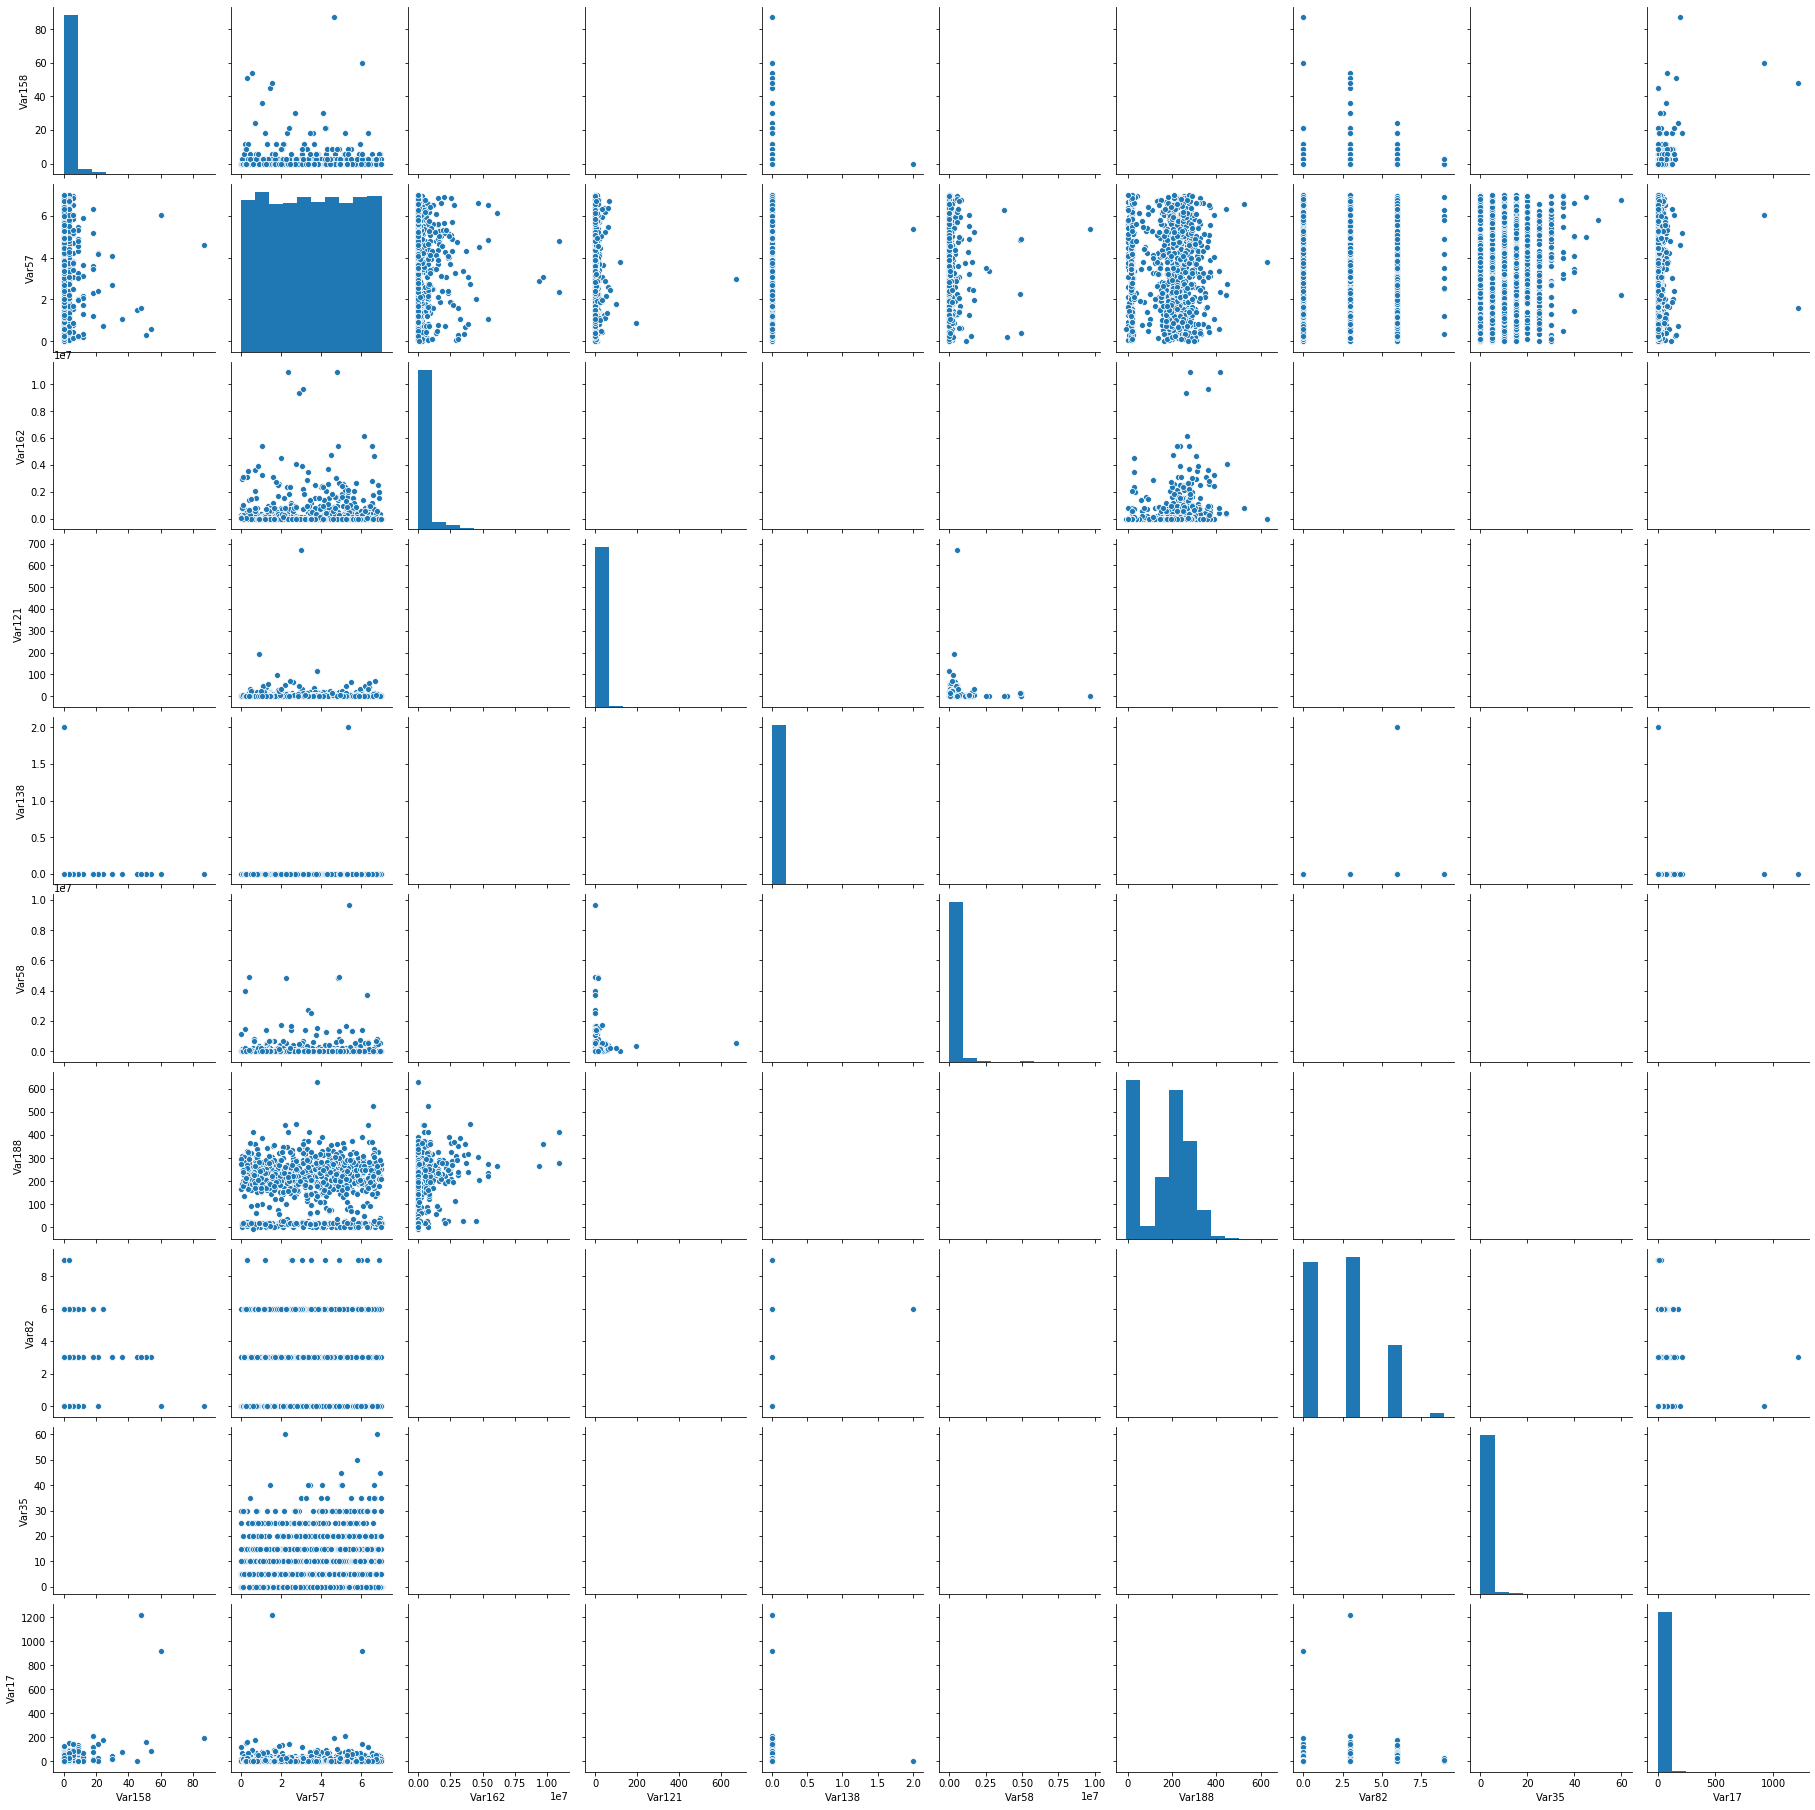

In [16]:
sns.pairplot(data[rand10_cols])

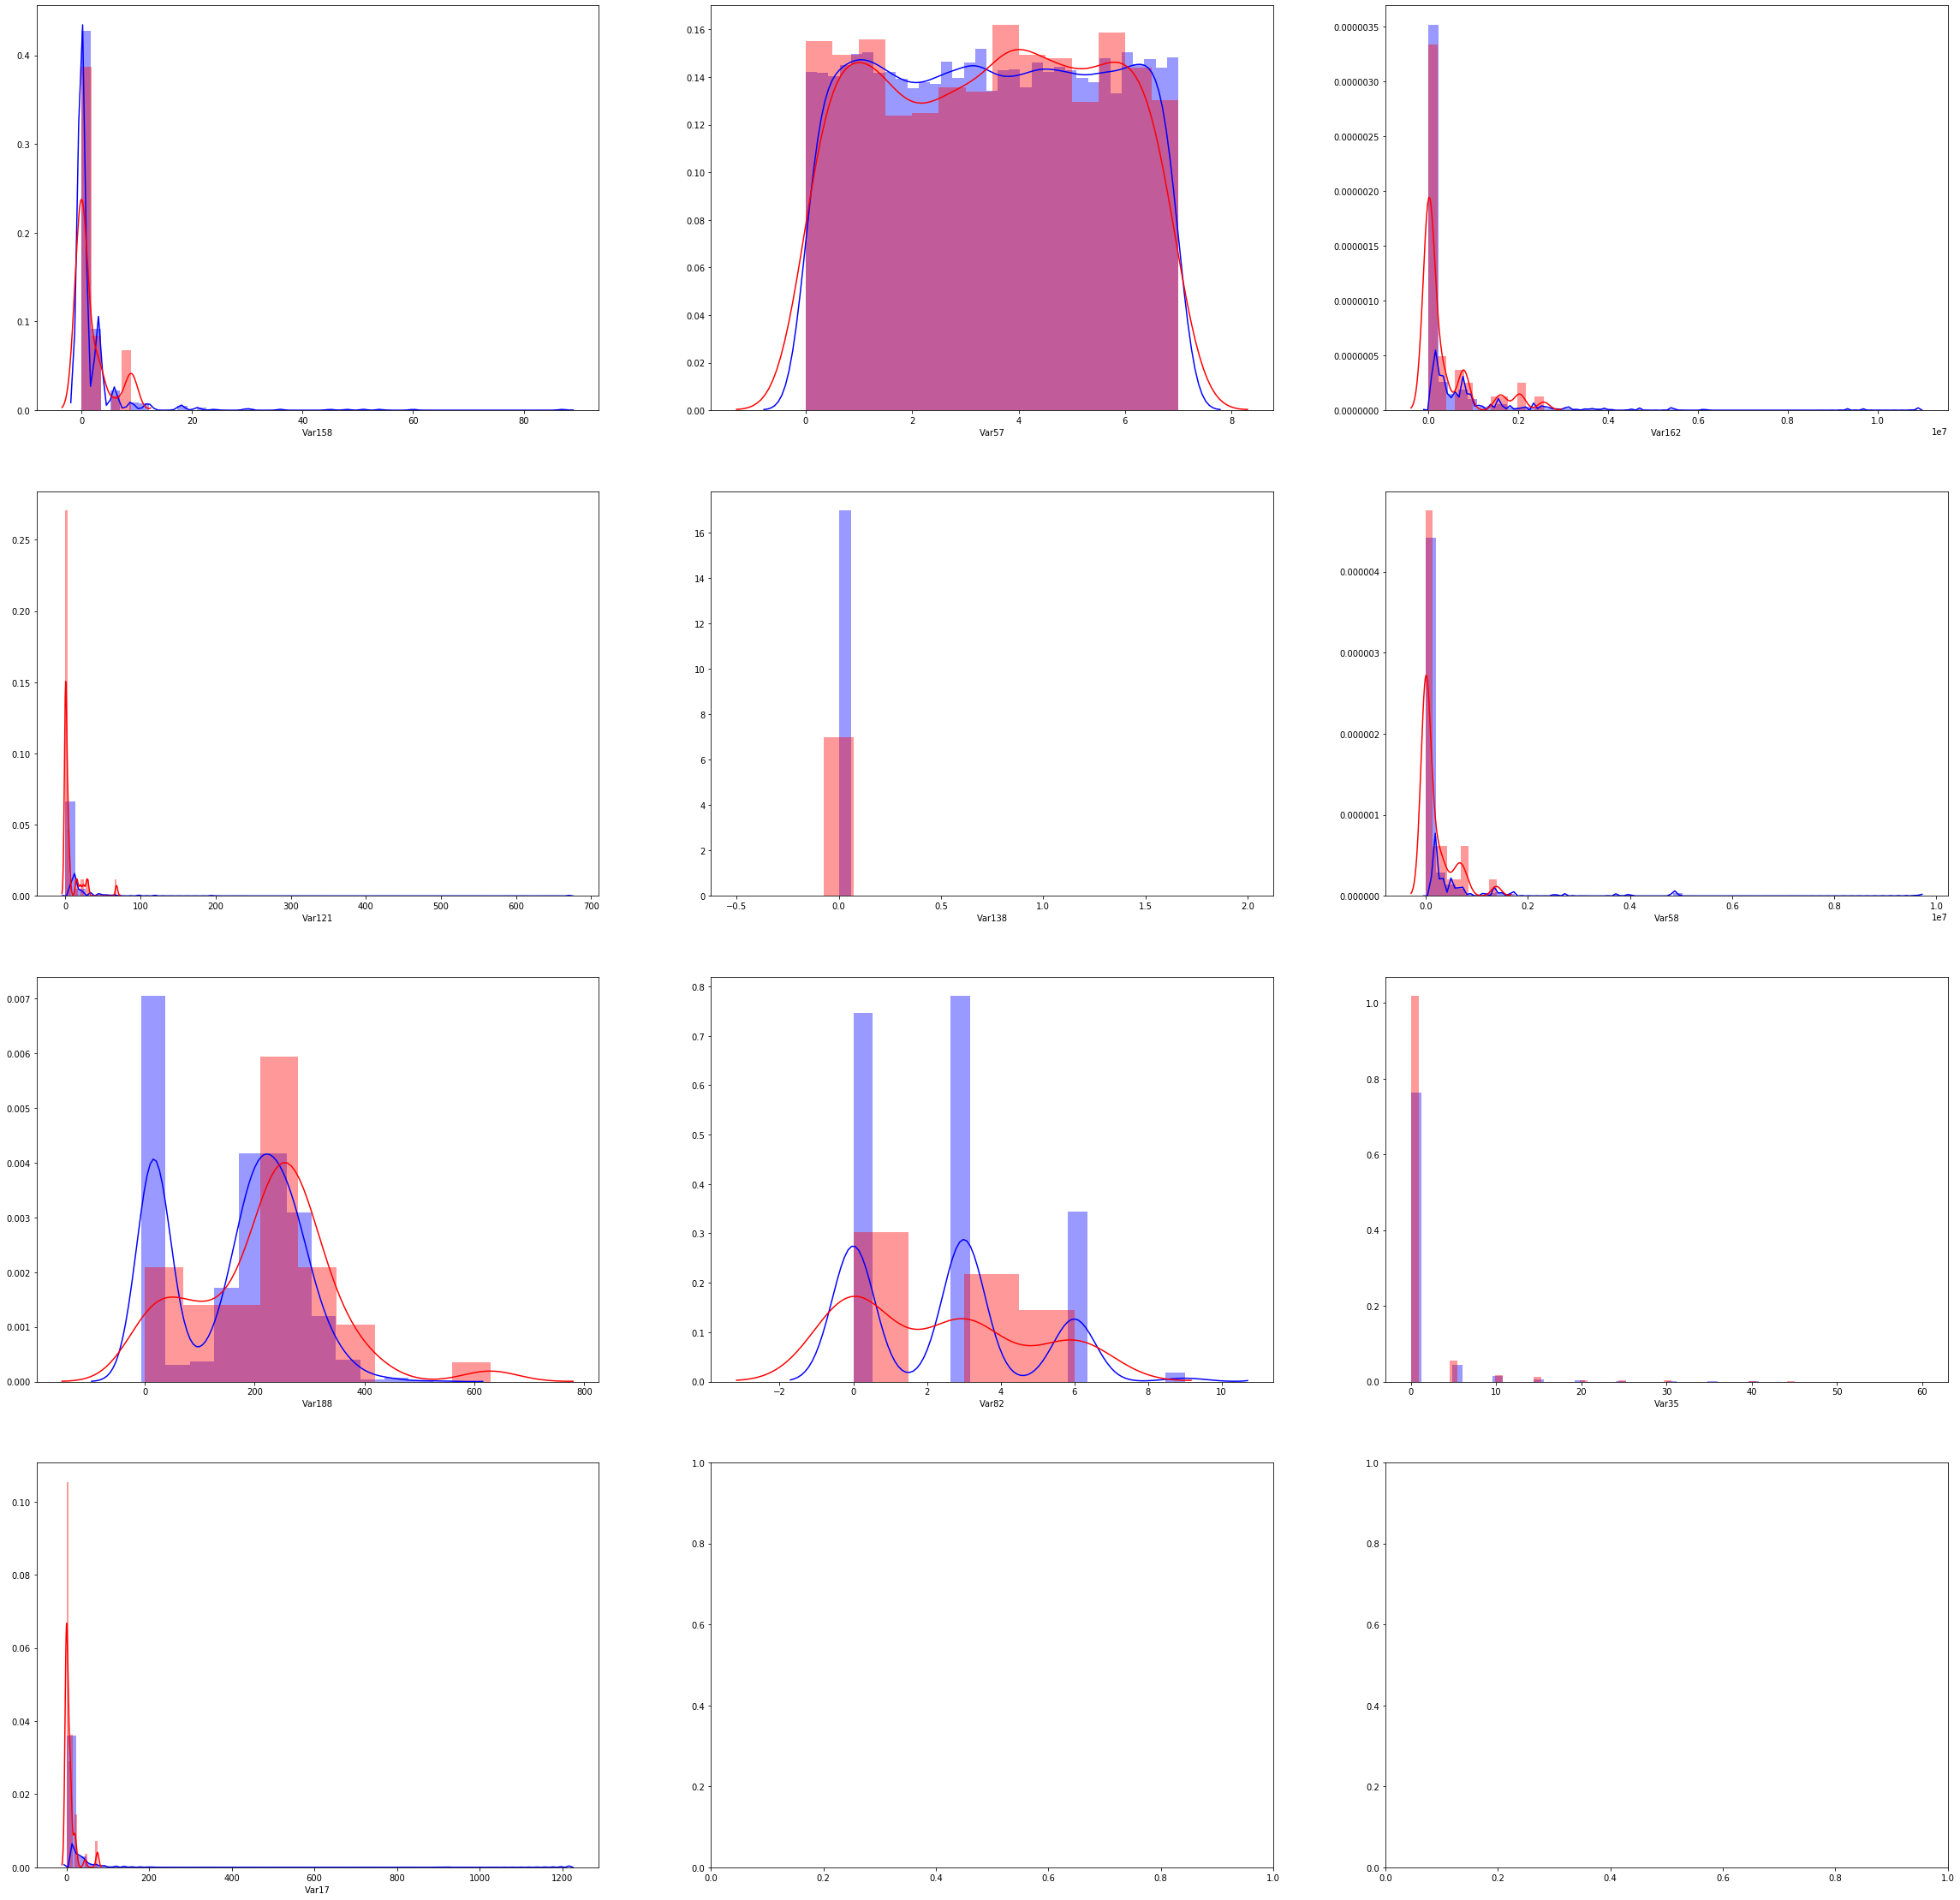

In [17]:
fig, axes = plt.subplots(int(len(rand10_cols)/3)+1, 3, figsize=(40, 40), sharey=False)
for i, var in enumerate(rand10_cols):
    sns.distplot(corr_params[corr_params.label == -1].loc[:, var], color='b', ax=axes[int(i / 3), i % 3], label='-1')
    sns.distplot(corr_params[corr_params.label == 1].loc[:, var], color='r', ax=axes[int(i / 3), i % 3], label = '1')

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [18]:
low_corr_var = labels_corr['label'].dropna().iloc[-10:].index

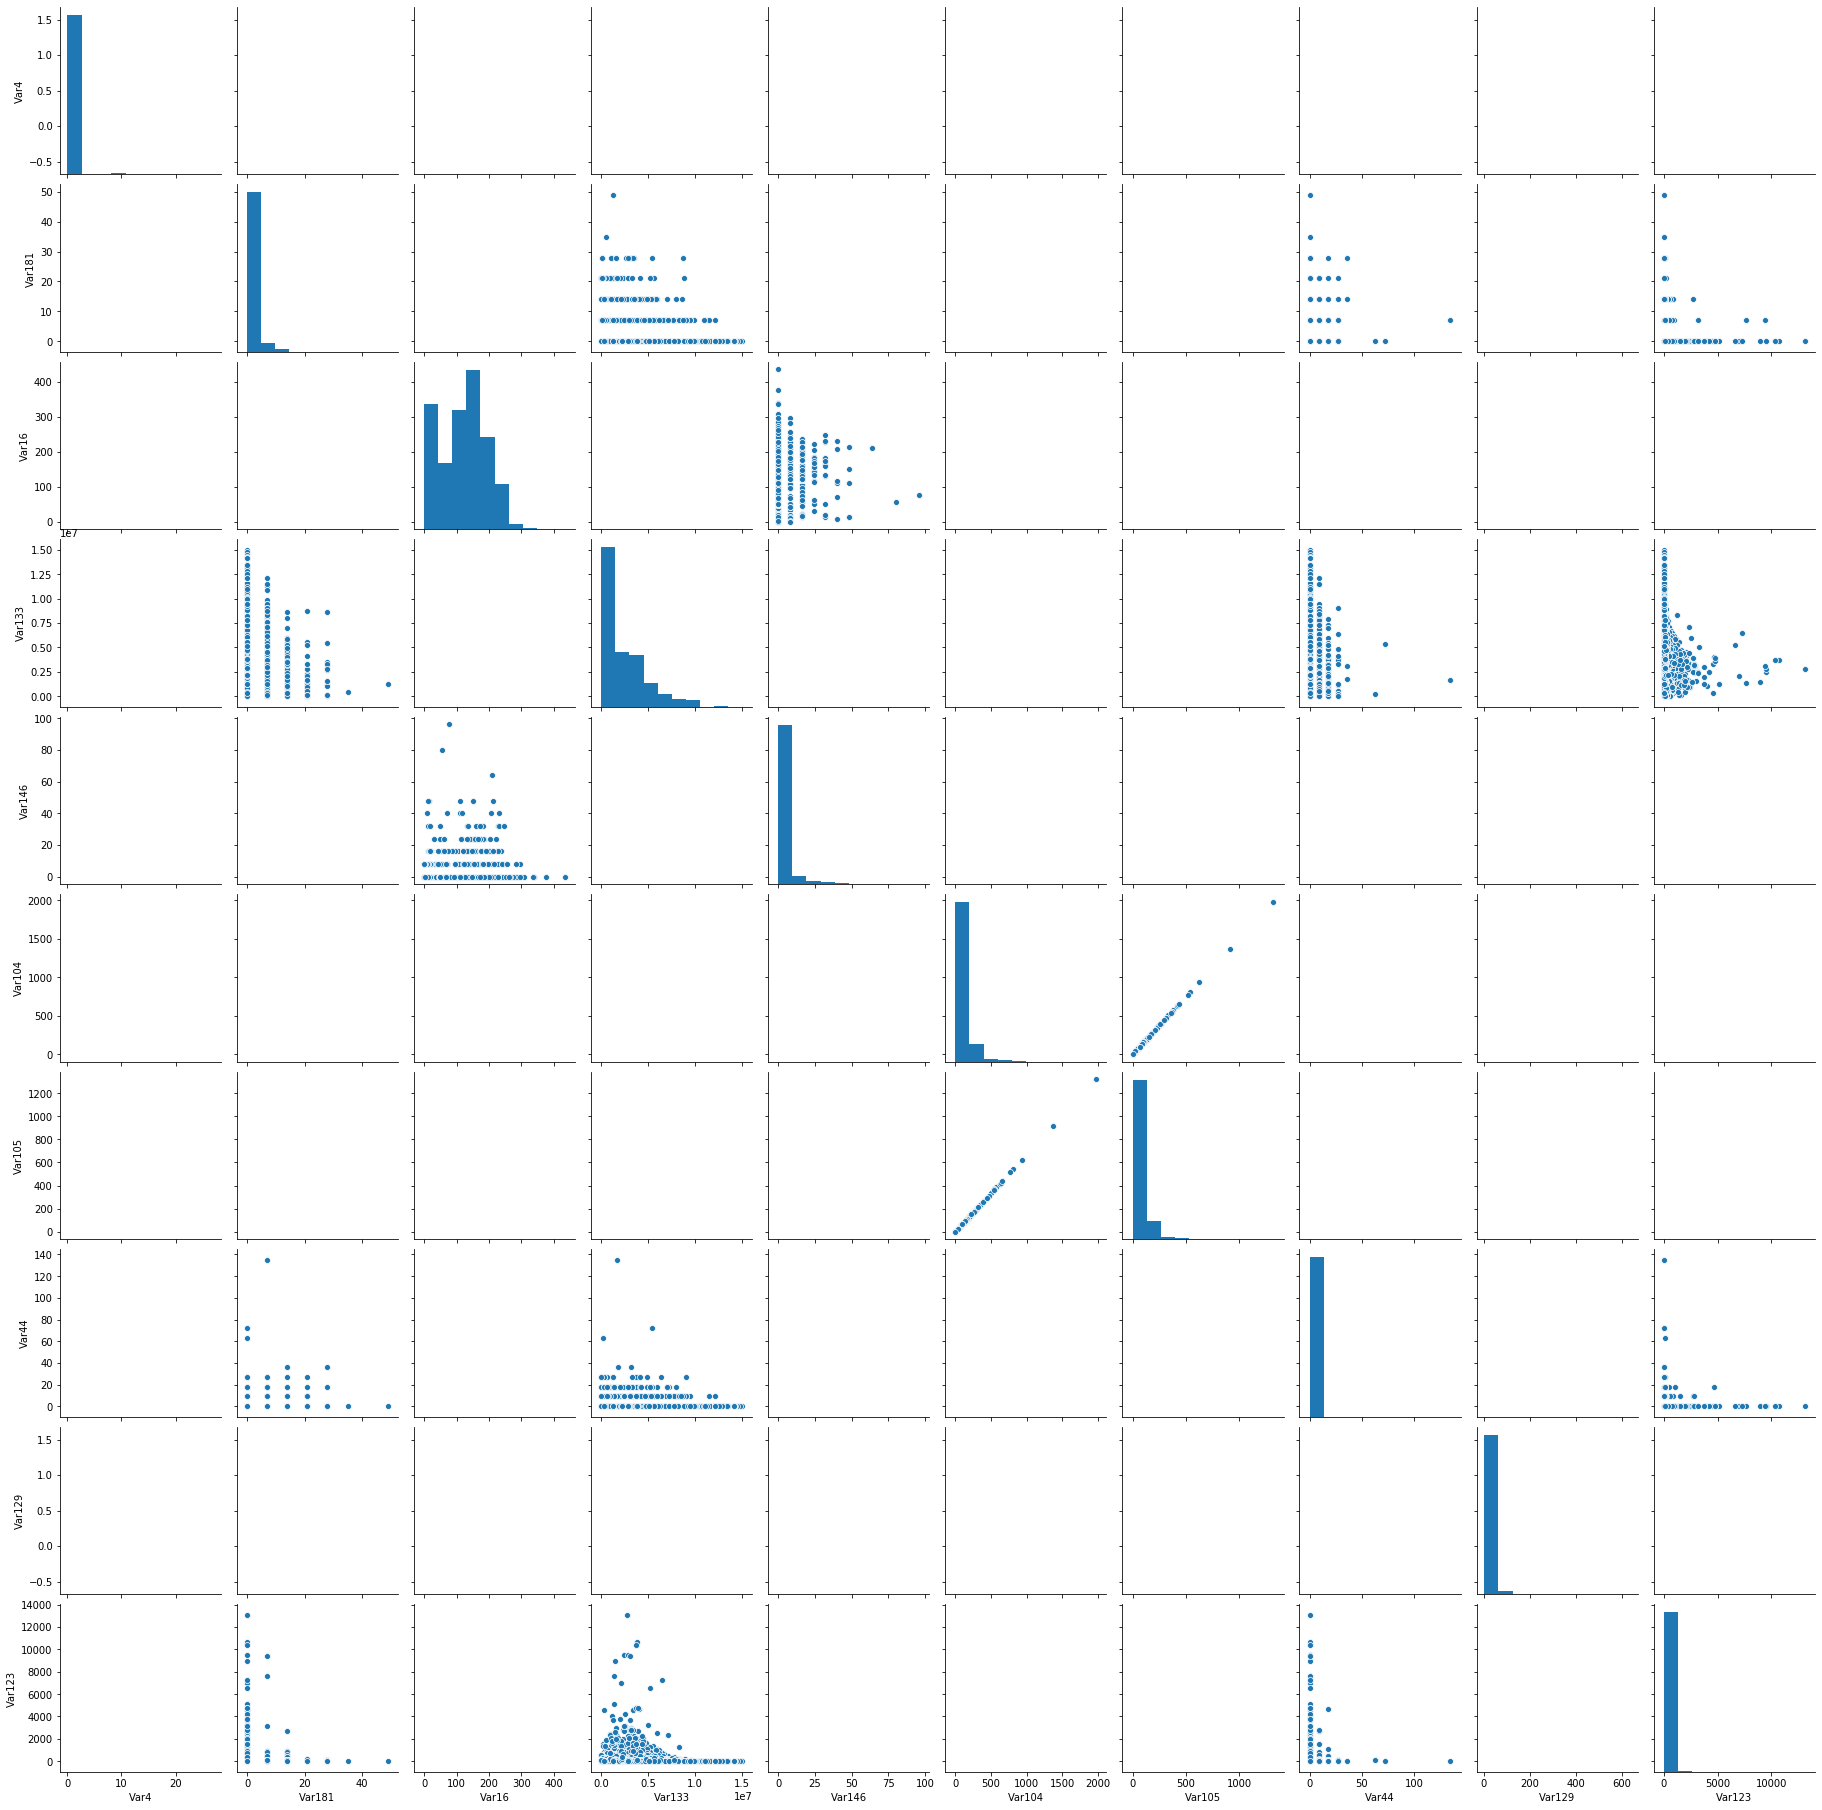

In [19]:
sns.pairplot(data[low_corr_var.to_list()])

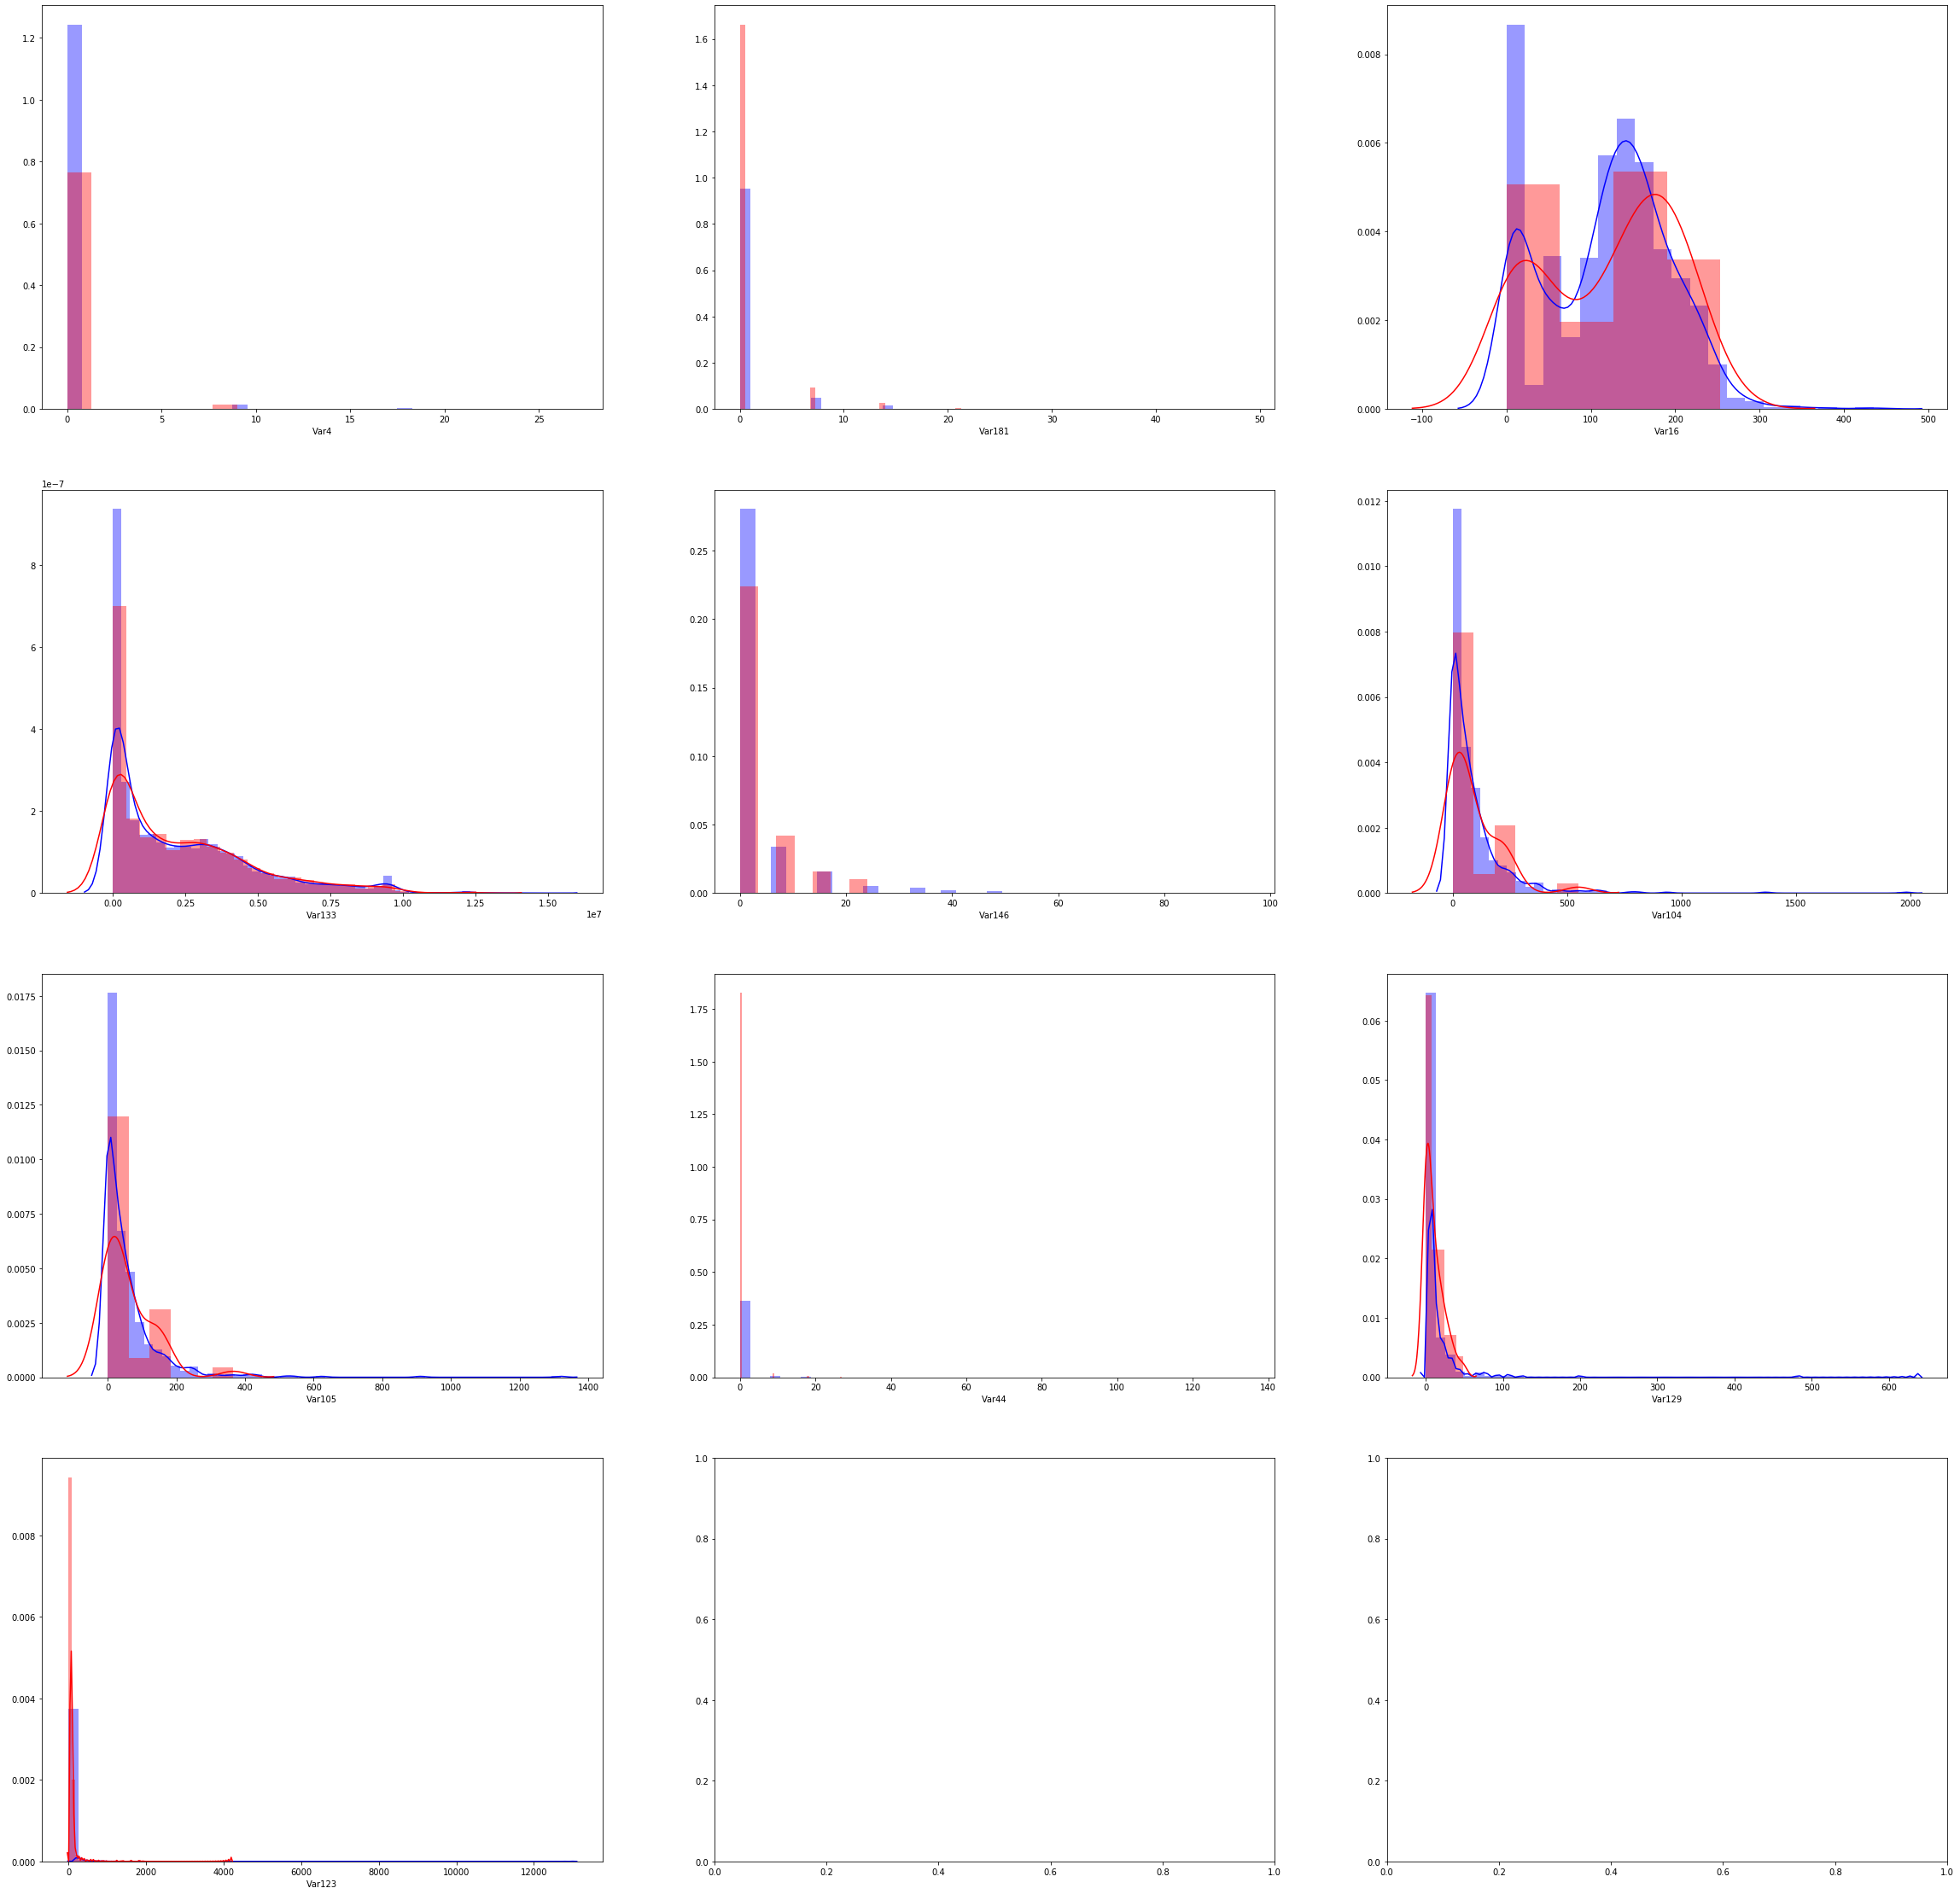

In [20]:
fig, axes = plt.subplots(int(len(low_corr_var)/3)+1, 3, figsize=(40, 40), sharey=False)
for i, var in enumerate(low_corr_var):
    sns.distplot(corr_params[corr_params.label == -1].loc[:, var], color='b', ax=axes[int(i / 3), i % 3], label='-1')
    sns.distplot(corr_params[corr_params.label == 1].loc[:, var], color='r', ax=axes[int(i / 3), i % 3], label = '1')

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

Var192 nunique 354
Var193 nunique 50
Var197 nunique 220
Var198 nunique 3891
Var199 nunique 4400
Var200 nunique 13297
Var202 nunique 5542
Var204 nunique 100
Var212 nunique 78
Var214 nunique 13297
Var216 nunique 1819
Var217 nunique 12470
Var220 nunique 3891
Var222 nunique 3891


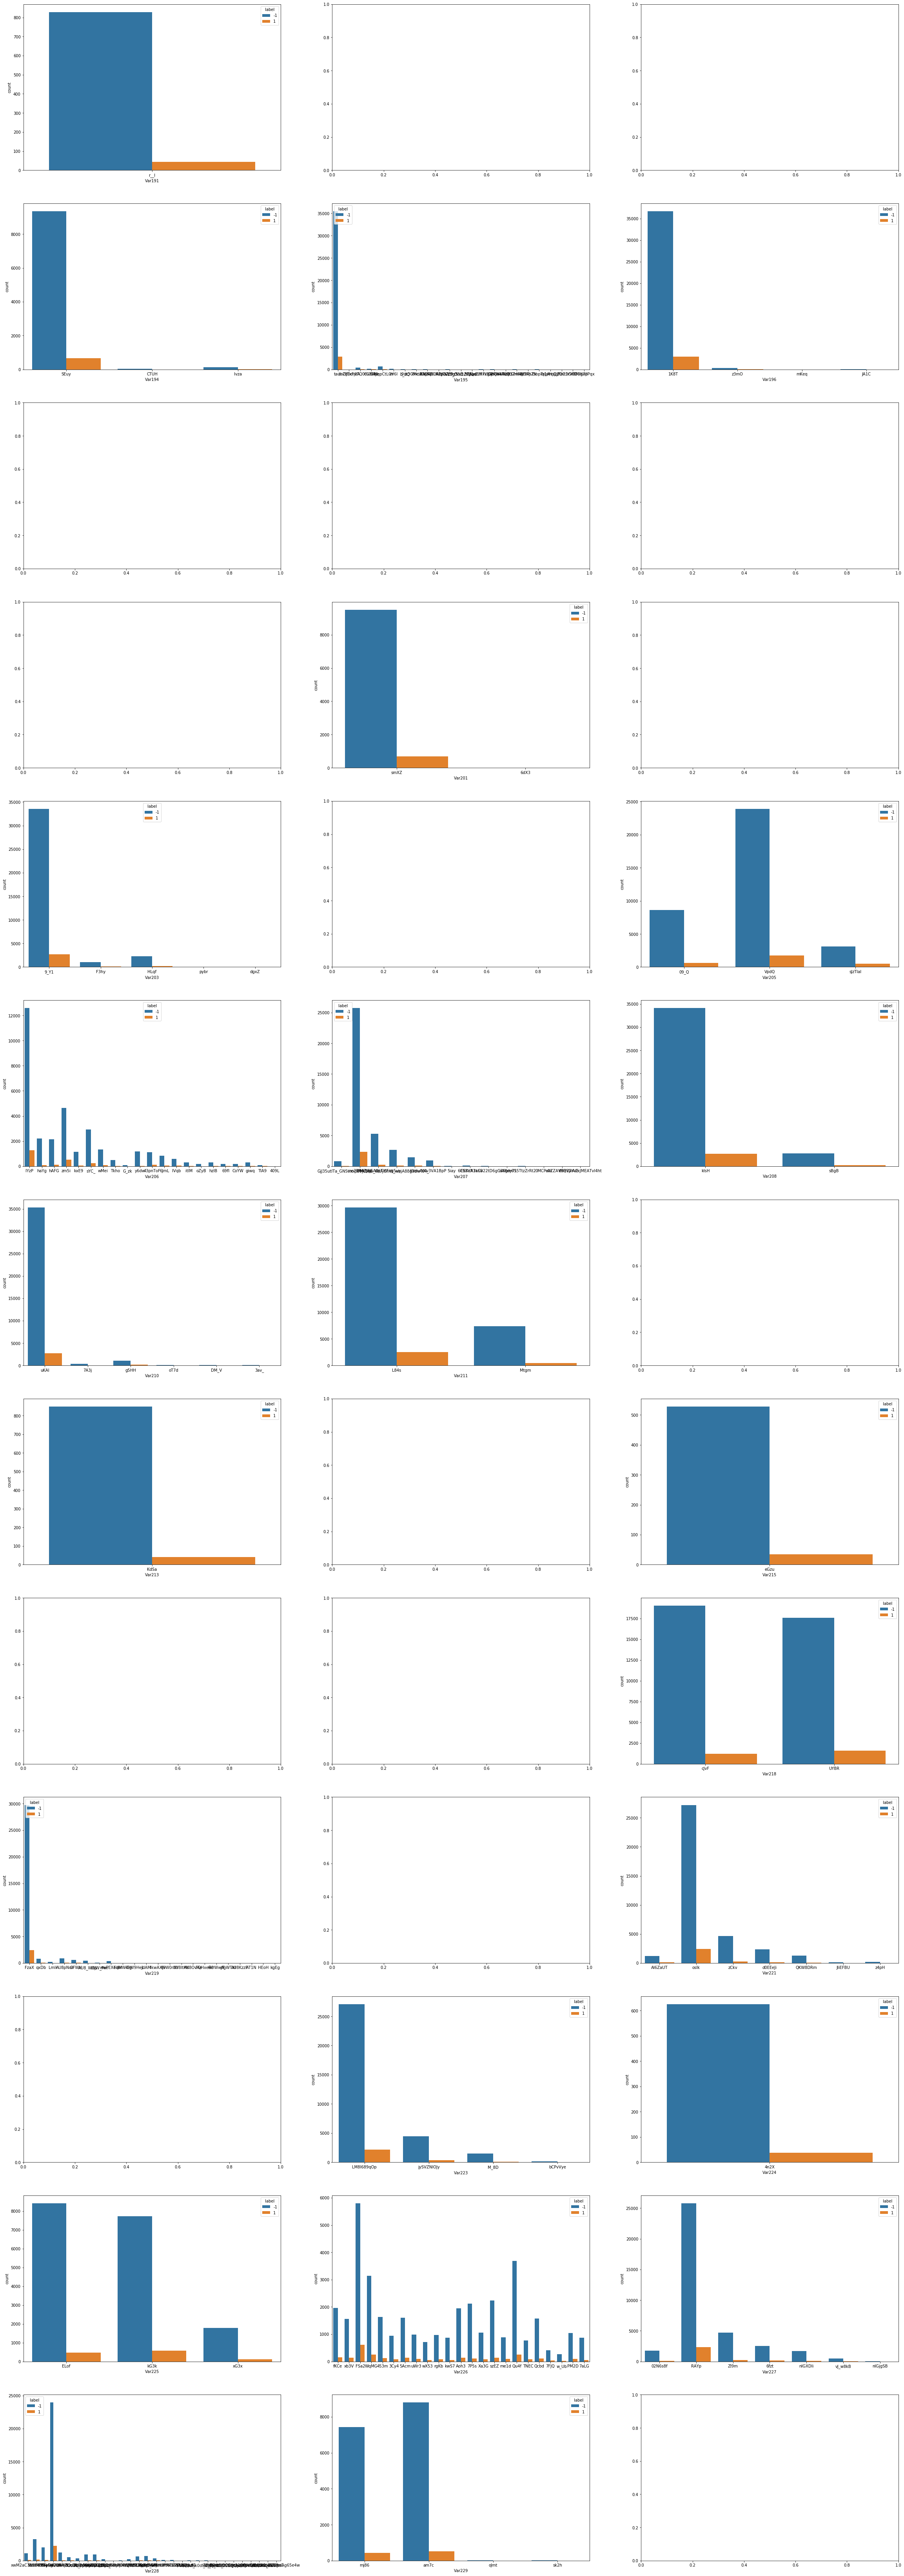

In [21]:
cat_and_labels = pd.concat([data.loc[:, object_cols], labels], axis=1)
fig, axes = plt.subplots(int(len(object_cols)/3)+1, 3, figsize=(40, 120), sharey=False)
cat_high_unique_val = []
for i, var in enumerate(object_cols):
    if cat_and_labels[var].nunique() < 50:
        sns.countplot(data=cat_and_labels, x=var, hue='label', ax=axes[int(i / 3), i % 3])
    else:
        print(var + ' nunique ' + str(cat_and_labels[var].nunique()))
        cat_high_unique_val.append(var)
    

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
Похоже что некоторые вещественные признаки являются вещественными. Среди категориальных некоторые признаки имеют слишком большой число уникальных значений, их в модели использовать не получится. Возможно в этих переменных закодированы какие-нибудь персональные данных. Например: ФИО, адрес итд. Некоторые категориальные переменные принимают только одно значение, необходимо попробовать заменить NA значением  отсутсвия данного признака и посмотреть на эти данные (191, 213, 215, 224) 
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
Для переменных с наибольшей корреляцией распределния переменной при различных значениях целевой функции различаются (VAR 168, 189, 131, 188, 53), предполагается, что эти переменные окажут наибольшее влияние. Также необходимо посмотреть категориальные переменные, при одном из значении котрого целевое значение равно только одному либо сильный перекос относительно среднего числа 1 и -1. Например VAR223. 
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
Шумовыми окажутся категориальные переменные с большим числом уникальных значений (198, 199, 200, 202, 214, 217, 220, 222) и вещественные признаки с большим числом пропусков (230, 209, 185, 175, 169).
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?
Думаю да, отакой отбор окажется полезным, поможет удалить заведомо неифнормативные признаки

Создадим отложенную выборку

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_hold, y_train, y_hold = train_test_split(data, labels, test_size=0.3, random_state=5, shuffle=True)

In [24]:
hold_out_data = pd.concat([X_hold, y_hold], axis=1)
train_data = pd.concat([X_train, y_train], axis=1)

In [25]:
hold_out_data.to_csv('Hold-out_data.csv')
train_data.to_csv('Train.csv')

### Построение baseline моделей

In [26]:
data = pd.read_csv('orange_small_churn_train_data.csv', index_col=0)
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [27]:
X = data.drop(columns=['labels'])
y = data['labels']

Выделим номера категориальных и вещественных колонок

In [28]:
num_cols = X.columns[:190]
cat_cols = X.columns[190:]

Удалим признаки в которых пропусков больше больше чем 0.3 от общей доли

In [29]:
numcol_nans = X[num_cols].isna().mean()
numeric_columns = numcol_nans[numcol_nans<0.3].index

Категориальные признаки разделим на 2 подгруппы, в первой число уникальных значений не более 30. Во второй - где больше. Признаки с большим число переменных использовать не будем. Возможно добавлю при улучшениии модели в задании следующей недели

In [30]:
category_columns1 = []
category_columns2 = []
for col in cat_cols:
    if X[col].nunique() > 30:
        category_columns2.append(col)
    else:
        category_columns1.append(col)

Построим Pipline для заполнения пропусков, энкодингда и стандартазации данных

In [31]:
def pipline_model (category_columns1, category_columns2, numeric_columns, classifier):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    category_steps2 = [('selection', FunctionTransformer(lambda x: x[category_columns2], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hashing', ce.BinaryEncoder(category_columns2))]
    return (Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1)),
            ('category2_variables_processing', Pipeline(steps = category_steps2))])),
            ('model_fitting', classifier)]))
                    

Напишем функцию для кросс валидации разных метрик

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
def get_cross_val_scores(classifier, X, y):
    pipline = pipline_model(category_columns1, category_columns2, numeric_columns, classifier)
    auc_scores = cross_val_score(pipline, X, y, cv=skf, scoring='roc_auc').mean()
    precision_scores = cross_val_score(pipline, X, y, cv=skf, scoring='precision').mean()
    recall_scores = cross_val_score(pipline, X, y, cv=skf, scoring='recall').mean()
    f_scores = cross_val_score(pipline, X, y, cv=skf, scoring='f1').mean()
    return([auc_scores, precision_scores, recall_scores, f_scores])

Обучим 4 модели RidgeClassifier, LogisticRegression c l1 регурляризатором, RandomForestClassifier, XGBClassifier

In [33]:
rc = RidgeClassifier(random_state=3)
lr = LogisticRegression(random_state=3, penalty='l1', solver='liblinear')
rf = RandomForestClassifier(random_state=3)
xg = XGBClassifier(random_state=3)

In [34]:
rc_scores = get_cross_val_scores(rc, X, y)

In [35]:
lr_scores = get_cross_val_scores(lr, X, y)

In [36]:
rf_scores = get_cross_val_scores(rf, X, y)

In [37]:
xg_scores = get_cross_val_scores(xg, X, y)

In [38]:
results = pd.DataFrame(rc_scores, columns = ['Ridge Classifier'], index = ['ROC-AUC', 'Precision', 'Recall', 'f1'])
results['Logistic Regression'] = lr_scores
results['RandomForestClassifier'] = rf_scores
results['XGB Classifier'] = xg_scores

Ниже в таблице представлены результаты baseline моделей

In [39]:
results.T

,ROC-AUC,Precision,Recall,f1
Ridge Classifier,0.653218,0.200000,0.000727,0.001449
Logistic Regression,0.660220,0.487879,0.013800,0.026627
RandomForestClassifier,0.646842,0.000000,0.000000,0.000000
XGB Classifier,0.721994,0.603333,0.008719,0.017163


## Построение и оптимизация модели Week4

Настроим параметры для логистической регрессии и градиентного бустинга

In [40]:
data_test = pd.read_csv('orange_small_churn_test_data.csv', index_col=0)
data_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN


Сначала попробуем подобрать параметры для логистической регрессии

Создадим scoring, для отслеживания одновременно нескольких метрик при подборе параметров

In [41]:
scoring = {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score), 'Precision': make_scorer(precision_score),
                    'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

In [42]:
pipe_lr = pipline_model(category_columns1, category_columns2, numeric_columns, lr)

In [43]:
lr_params = {'model_fitting__C': np.logspace(-3, 2, num=5)}
lr_grid = GridSearchCV(pipe_lr, param_grid = lr_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [44]:
lr_grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model.<locals>.<lambda> at 0x000001826159A2F0>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         StandardS...
                                       ('model_fitting',
        

Ниже представлена настройка XGB Classifier. Так как время и мощности не позволяют посмотреть на все параметры одновременно - параметры настраивал последовательно

In [45]:
xg = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3,
         min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.7,
         objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha= 0.05, random_state=3)
pipe_xg = pipline_model(category_columns1, category_columns2, numeric_columns, xg)

In [46]:
xg_params = {
 'model_fitting__reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [47]:
%%time
xg_grid.fit(X,y)

Wall time: 2min 59s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model.<locals>.<lambda> at 0x000001825A923C80>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         StandardS...
                                       ('model_fitting',
        

In [48]:
cv_result = pd.DataFrame.from_dict(xg_grid.cv_results_).sort_values(by='rank_test_AUC')
cv_result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)

,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
4,{'model_fitting__reg_alpha': 0.05},0.717755,0.017439,0.650000,0.033904
3,{'model_fitting__reg_alpha': 0.01},0.716725,0.015987,0.613889,0.031111
2,{'model_fitting__reg_alpha': 0.005},0.715805,0.014535,0.611111,0.028325
1,{'model_fitting__reg_alpha': 0.001},0.714823,0.015987,0.592540,0.031086
0,{'model_fitting__reg_alpha': 0},0.714819,0.015987,0.592540,0.031086


Ниже  приведен код, который я вставлял различные модели и проверял резльутаты на kaggle

In [49]:
result = xg_grid.best_estimator_.predict_proba(data_test)
to_kaggle = pd.DataFrame(result[:,1], columns = ['result'])#
to_kaggle.index.name = 'Id'
to_kaggle.to_csv('Week4_tuned.csv')

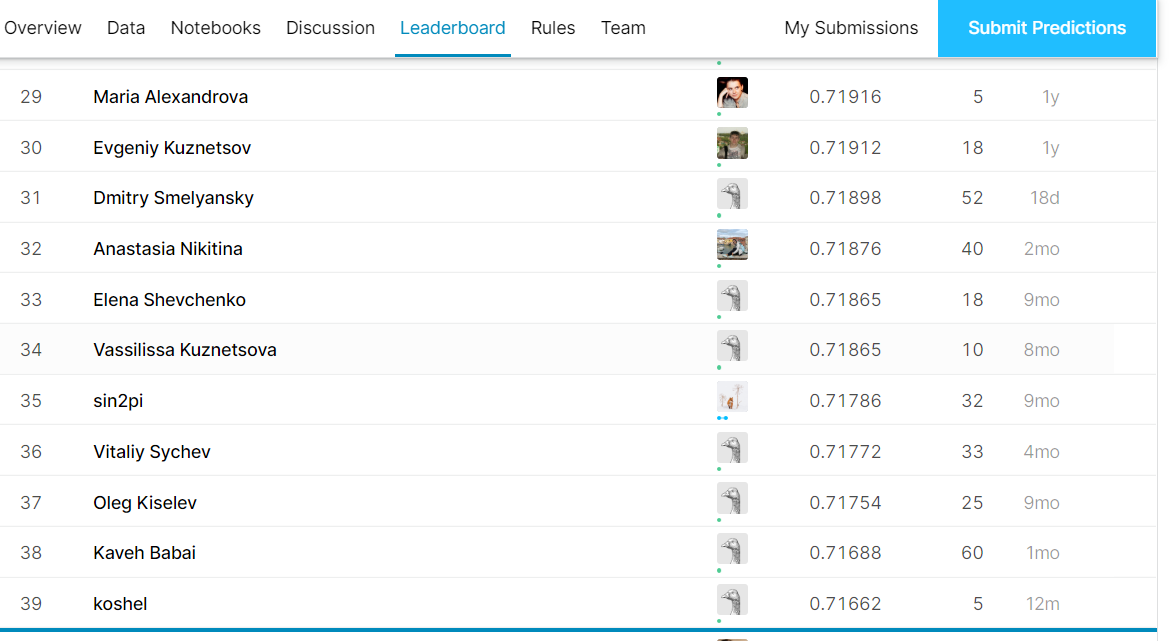

#### 39 место

Лучшим решением оказался ненастроенный XGBoost Classifier, по всей видимости последовательная настройка параметров оказалось плохой идеей и загнало решение в локальный минимум, который выше базового решения. Логистическая регрессия также перешла порог baseline решения.

# Peer-graded Assignment: Эксперименты с моделью Week5

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции 

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [50]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [51]:
xg = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3,
         min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.7,
         objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha= 0.05, random_state=3)
pipe_xg = pipline_model(category_columns1, category_columns2, numeric_columns, xg)

In [52]:
train_sizes, train_scores, test_scores = learning_curve(pipe_xg, X, y, cv=skf, n_jobs=-1, scoring='roc_auc', random_state=3)

In [53]:
def plot_learning_curve(train_scores, test_scores, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, train_scores, label='train')
    plot_with_err(train_sizes, test_scores, label='test')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

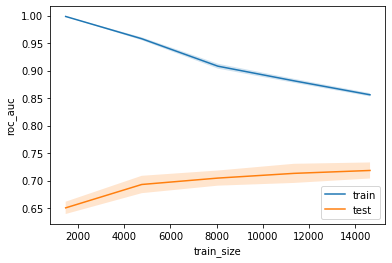

In [54]:
plot_learning_curve(train_scores, test_scores, train_sizes, 
                    xlabel='train_size', ylabel='roc_auc')

При размере выборки примерно от 7000 - качество модели практически не улучшается

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [55]:
xg = XGBClassifier(random_state=3)
pipe_xg = pipline_model(category_columns1, category_columns2, numeric_columns, xg)

In [56]:
xg_params = {
 'model_fitting__scale_pos_weight':[0.1, 1, 3, 8, 10, 13, 15]
            }
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [57]:
%%time
xg_grid.fit(X,y)

Wall time: 9min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model.<locals>.<lambda> at 0x00000182666AFEA0>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         StandardS...
                                                                 

In [58]:
cv_result = pd.DataFrame.from_dict(xg_grid.cv_results_).sort_values(by='rank_test_AUC')
cv_result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)

,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
0,{'model_fitting__scale_pos_weight': 0.1},0.725357,0.000000,0.000000,0.000000
1,{'model_fitting__scale_pos_weight': 1},0.721994,0.008719,0.603333,0.017163
2,{'model_fitting__scale_pos_weight': 3},0.721433,0.095868,0.357786,0.151186
4,{'model_fitting__scale_pos_weight': 10},0.719407,0.493858,0.167284,0.249818
3,{'model_fitting__scale_pos_weight': 8},0.717705,0.388551,0.197516,0.261814
5,{'model_fitting__scale_pos_weight': 13},0.716339,0.615863,0.136159,0.222934
6,{'model_fitting__scale_pos_weight': 15},0.715029,0.674672,0.123657,0.208978


Лучший результат при scale_pos_weigh=0.1 - но в таком случае самые сильные ошибки совершаются на классе 1, соответсвенно класификатор теряет всякий смысл. Далее в работе используется scale_pos_weigh=1

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Воспользуемся библиотекой imblearn для реализации undersampling. Преобразуем Pipeline написанные ранее, добавив туда шаг с undersampling'ом. Попробуем 3 типа undersampling'a: RandomUnderSampler ClusterCentroids, NearMiss - version=1

In [59]:
def pipline_model_us (category_columns1, category_columns2, numeric_columns, classifier, sampler):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    category_steps2 = [('selection', FunctionTransformer(lambda x: x[category_columns2], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hashing', ce.BinaryEncoder(category_columns2))]
    return (iPipline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1)),
            ('category2_variables_processing', Pipeline(steps = category_steps2))])),
            ('undersampling', sampler),
            ('model_fitting', classifier)]))

In [60]:
rus = RandomUnderSampler(random_state=3)
ccus = ClusterCentroids(random_state=3)
nmus = NearMiss()

In [61]:
pipe_xg_rus = pipline_model_us(category_columns1, category_columns2, numeric_columns, xg, rus)
pipe_xg_ccus = pipline_model_us(category_columns1, category_columns2, numeric_columns, xg, ccus)
pipe_xg_nmus = pipline_model_us(category_columns1, category_columns2, numeric_columns, xg, nmus)

In [62]:
xg_params={}
xg_grid_rus = GridSearchCV(pipe_xg_rus, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')
xg_grid_ccus = GridSearchCV(pipe_xg_ccus, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')
xg_grid_nmus = GridSearchCV(pipe_xg_nmus, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [63]:
%%time
xg_grid_rus.fit(X,y)
xg_grid_ccus.fit(X,y)
xg_grid_nmus.fit(X,y)

Wall time: 18min 46s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model_us.<locals>.<lambda> at 0x00000182611E0620>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         Standa...
                                                                 

In [64]:
rus_res = pd.DataFrame.from_dict(xg_grid_rus.cv_results_)
ccus_res = pd.DataFrame.from_dict(xg_grid_ccus.cv_results_)
nmus_res = pd.DataFrame.from_dict(xg_grid_nmus.cv_results_)
result = pd.concat([rus_res, ccus_res, nmus_res], axis=0)
result.index = ['Random', 'Cluster Centroids', 'Near Miss']

In [65]:
result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)

,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
Random,{},0.706199,0.670332,0.128165,0.215123
Cluster Centroids,{},0.614958,0.980406,0.075008,0.139354
Near Miss,{},0.471923,0.760329,0.074608,0.135881


Лучший результат показал Random undersampling. Но качество модели снизилось, поэтому пока что не будем применять undersampling

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [66]:
def pipline_model (category_columns1, category_columns2, numeric_columns, classifier):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    category_steps2 = [('selection', FunctionTransformer(lambda x: x[category_columns2], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hashing', ce.BinaryEncoder(category_columns2))]
    return (Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1)),
            ('category2_variables_processing', Pipeline(steps = category_steps2))])),
            ('model_fitting', classifier)]))
                    

In [67]:
pipe_xg = pipline_model(category_columns1, category_columns2, numeric_columns, xg)
xg_params={'feature_processing__numeric_variables_processing__imputing__strategy': ['mean', 'median', 'most_frequent']}
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [68]:
%%time
xg_grid.fit(X,y)

Wall time: 4min 26s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model.<locals>.<lambda> at 0x0000018260202620>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         StandardS...
                                                                 

In [69]:
cv_result = pd.DataFrame.from_dict(xg_grid.cv_results_).sort_values(by='rank_test_AUC')
cv_result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)

,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
0,{'feature_processing__numeric_variables_proces...,0.721994,0.008719,0.603333,0.017163
2,{'feature_processing__numeric_variables_proces...,0.716455,0.007989,0.620000,0.015766
1,{'feature_processing__numeric_variables_proces...,0.715311,0.008722,0.530000,0.017158


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [70]:
pipe_xg = pipline_model(category_columns1, category_columns2, numeric_columns, xg)
xg_params={'feature_processing__category2_variables_processing__hashing':
           [LabelEncoder(),
             ce.BinaryEncoder(category_columns2), ce.CatBoostEncoder(category_columns2)]}
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [71]:
%%time
xg_grid.fit(X,y)

Wall time: 2min 41s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model.<locals>.<lambda> at 0x0000018261339598>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         StandardS...
                                                                 

In [72]:
cv_result = pd.DataFrame.from_dict(xg_grid.cv_results_).sort_values(by='rank_test_AUC')
cv_result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)

,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
1,{'feature_processing__category2_variables_proc...,0.721994,0.008719,0.603333,0.017163
2,{'feature_processing__category2_variables_proc...,0.719826,0.007265,0.616667,0.014352
0,{'feature_processing__category2_variables_proc...,NaN,NaN,NaN,NaN


Для признаков category 1 -лучшим способом из OneHotEncoder(handle_unknown = 'ignore', sparse=False), ce.BinaryEncoder(category_columns1), ce.CatBoostEncoder(category_columns1) - OneHotEncode. Для category 2 - Binary_Encoder

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [73]:
def pipline_model_fs (category_columns1, category_columns2, numeric_columns, classifier):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    category_steps2 = [('selection', FunctionTransformer(lambda x: x[category_columns2], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hashing', ce.BinaryEncoder(category_columns2))]
    return (Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1)),
            ('category2_variables_processing', Pipeline(steps = category_steps2))])),
            ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
            ('model_fitting', classifier)]))
                    

In [74]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
xg = XGBClassifier(random_state=3)
pipe_xg = pipline_model_fs(category_columns1, category_columns2, numeric_columns, xg)

In [76]:
xg_params={}
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [77]:
%%time
xg_grid.fit(X,y)

Wall time: 47.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model_fs.<locals>.<lambda> at 0x0000018269D117B8>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         Standa...
                                                                 

In [78]:
pd.DataFrame.from_dict(xg_grid.cv_results_).iloc[:,:16]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_Precision,split1_test_Precision,split2_test_Precision
0,7.497954,0.222107,0.301568,0.003715,{},0.710815,0.705934,0.719949,0.729202,0.754608,0.724102,0.017207,1,0.75,0.333333,0.5


Было проверено 2 способа отбора признаков, с помощью Lasso и ExtraTreesClassifier. Для Lasso было подобрано alpha, для  ExtraTreesClassifier - число деревьев. Lasso best score 0.724102, ExtraTreesClassifier best score - 0.722086. C небольшим отрывом по качеству побеждает Lasso при alpha = 0.001

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

В пайплайн был добавлен шаг undersampling'a потому что после проверки значений, на которых модель ошибается сильнее все - практически все значения целевого класса были 1. Данный шаг помог увеличить Precision, без сильной потери в AUC

In [79]:
def pipline_model_fs_us (category_columns1, category_columns2, numeric_columns, classifier, sampler):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    category_steps2 = [('selection', FunctionTransformer(lambda x: x[category_columns2], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hashing', ce.BinaryEncoder(category_columns2))]
    return (iPipline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1)),
            ('category2_variables_processing', Pipeline(steps = category_steps2))])),
            ('undersampling', sampler),
            ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
            ('model_fitting', classifier)]))

In [80]:
xg = XGBClassifier(random_state=3)
pipe_xg = pipline_model_fs_us (category_columns1, category_columns2, numeric_columns, xg, RandomUnderSampler(random_state=3))
xg_params={'model_fitting__max_depth':[2, 3, 5], 'model_fitting__n_estimators': [50, 100, 150],
           'model_fitting__min_child_weight': [1, 2, 5], 'model_fitting__gamma':[0, 0.1, 0.2]}
xg_grid = GridSearchCV(pipe_xg, param_grid = xg_params,
                          cv=skf, scoring=scoring, refit='AUC')

In [81]:
%%time
xg_grid.fit(X,y)

Wall time: 19min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selection',
                                                                                         FunctionTransformer(func=<function pipline_model_fs_us.<locals>.<lambda> at 0x0000018260202378>)),
                                                                                        ('imputing',
                                                                                         SimpleImputer()),
                                                                                        ('scaling',
                                                                                         Sta...
                                       ('model_fitting',
        

In [82]:
cv_result = pd.DataFrame.from_dict(xg_grid.cv_results_).sort_values(by='rank_test_AUC')
cv_result[['params', 'mean_test_AUC', 'mean_test_Recall','mean_test_Precision', 'mean_test_f1_score']].head(10)


,params,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_f1_score
30,"{'model_fitting__gamma': 0.1, 'model_fitting__...",0.715285,0.692105,0.127400,0.215074
3,"{'model_fitting__gamma': 0, 'model_fitting__ma...",0.715285,0.692105,0.127400,0.215074
57,"{'model_fitting__gamma': 0.2, 'model_fitting__...",0.715285,0.692105,0.127400,0.215074
0,"{'model_fitting__gamma': 0, 'model_fitting__ma...",0.714549,0.690656,0.125821,0.212768
27,"{'model_fitting__gamma': 0.1, 'model_fitting__...",0.714549,0.690656,0.125821,0.212768
54,"{'model_fitting__gamma': 0.2, 'model_fitting__...",0.714549,0.690656,0.125821,0.212768
6,"{'model_fitting__gamma': 0, 'model_fitting__ma...",0.714422,0.690664,0.126771,0.214145
60,"{'model_fitting__gamma': 0.2, 'model_fitting__...",0.714422,0.690664,0.126771,0.214145
33,"{'model_fitting__gamma': 0.1, 'model_fitting__...",0.714422,0.690664,0.126771,0.214145
31,"{'model_fitting__gamma': 0.1, 'model_fitting__...",0.712819,0.681215,0.128678,0.216404


In [83]:
xg_grid.best_params_

{'model_fitting__gamma': 0,
 'model_fitting__max_depth': 2,
 'model_fitting__min_child_weight': 2,
 'model_fitting__n_estimators': 50}

Перебор параметров не дал результатов. {'model_fitting__gamma': 0,
 'model_fitting__max_depth': 3,
 'model_fitting__min_child_weight ': 1,
 'model_fitting__n_estimators': 50}. Единственное, можно снизиить число деревьев до 50 без потери в качестве

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [84]:
cat1_feature_names = xg_grid.best_estimator_.get_params()['steps'][0][1].get_params(
                )['transformer_list'][1][1].get_params()['steps'][2][1].get_feature_names()

In [85]:
cat2_feature_names = xg_grid.best_estimator_.get_params()['steps'][0][1].get_params(
                )['transformer_list'][2][1].get_params()['steps'][2][1].get_feature_names()

In [86]:
all_feature_names = numeric_columns.tolist() + cat1_feature_names.tolist() + cat2_feature_names

In [87]:
selected_features = xg_grid.best_estimator_.named_steps['feature_selection'].get_support()

In [88]:
features_df = pd.DataFrame(selected_features, index=all_feature_names, columns=['selected'])

In [89]:
features_importance = features_df[features_df.selected == True]

In [90]:
features_importance['features_importance'] = xg_grid.best_estimator_.named_steps['model_fitting'].feature_importances_

In [91]:
features_importance.sort_values(by='features_importance', ascending=False).iloc[:10], features_importance.sort_values(by='features_importance', ascending=False).iloc[-10:]

(             selected  features_importance
 Var126           True             0.086470
 x24_unknown      True             0.074601
 Var13            True             0.070858
 Var73            True             0.059376
 x6_sJzTlal       True             0.052724
 Var74            True             0.042069
 x15_unknown      True             0.036053
 x15_cJvF         True             0.035868
 11_2             True             0.031534
 Var81            True             0.031321,
              selected  features_importance
 x21_fKCe         True                  0.0
 x21_kwS7         True                  0.0
 x21_me1d         True                  0.0
 x21_rgKb         True                  0.0
 x21_szEZ         True                  0.0
 x21_uWr3         True                  0.0
 x21_wX53         True                  0.0
 x21_xb3V         True                  0.0
 x22_nIGXDli      True                  0.0
 13_12            True                  0.0)

Выше представлена таблицы с 10-ю наиболее важными признаками и неважными

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [92]:
data_hold_out = pd.read_csv('Hold-out_data.csv', index_col=0)
data_hold_out.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,label
20361,NaN,NaN,NaN,NaN,NaN,2114.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,fKCe,ZI9m,ib5G6X1eUxUn6,NaN,NaN,-1
29402,NaN,NaN,NaN,NaN,NaN,644.0,7.0,NaN,NaN,NaN,...,3L2y2B0,LM8l689qOp,NaN,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86,NaN,-1
16118,NaN,NaN,NaN,NaN,NaN,1449.0,7.0,NaN,NaN,NaN,...,pfUTE6Y,LM8l689qOp,NaN,ELof,szEZ,RAYp,F2FyR07IdsN7I,mj86,NaN,-1
39019,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,...,O8szlpr,LM8l689qOp,NaN,NaN,5Acm,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
9706,NaN,NaN,NaN,NaN,NaN,140.0,0.0,NaN,NaN,NaN,...,r7hqjNq,LM8l689qOp,NaN,NaN,Aoh3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [93]:
predicted = pd.DataFrame(xg_grid.best_estimator_.predict_proba(data_hold_out.drop(columns=['label']))[:,1], columns = ['pred_prob'],
                        index=data_hold_out.index)

predicted['true'] = data_hold_out.label

In [94]:
predicted['error'] = predicted[['pred_prob', 'true']].apply(lambda x: 1-x[0] if x[1]==1 else x[0], axis=1)

In [95]:
predicted.sort_values(by='error', ascending=False).iloc[:100, 1].value_counts()

-1    93
 1     7
Name: true, dtype: int64

Выше представлено распределение меток целевого класса среди 100 значений, на которых модель ошибается сильнее всего

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

1. Очень важным оказалось использование undersampling'a помогло снизить число ошибок на целевом классе равном одному. Но из-за него качество модели снизилось, по метрике roc-auc и соревнования
2. Полезным оказался отбор признаков с помощью Лассо. Это улучшило модель
3. При подборе параметров выяснилось, что число деревьев 50 дает такой же результат как и 100, соответсвенно без потери в качество получилось увеличить скорость выполнения модели

In [96]:
%%time
result = xg_grid.best_estimator_.predict_proba(data_test)
to_kaggle = pd.DataFrame(result[:,1], columns = ['result'])#
to_kaggle.index.name = 'Id'
to_kaggle.to_csv('Week5_tuned.csv')

Wall time: 730 ms


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

После всех этих настроек качество модели снизилось. Можно попробовать другое заполнение пропусков MI (multiple imputation). Другие способы undersampling'a или попробовать oversampling. И проверить другой классификатор

## Week 6 Оценка эффекта от внедрения полученного решения

Пусть пользователь приносит 100 рублей чистой прибыли ежемесячно. 
В удержание пользователя будем вкладывать 20 ежемесячно. То есть преложим ему тариф на 20р дешевле, чем он был изначально. Улучшенные условия будем предлагать 10% пользователей с наибольшей вероятностью к уходу. Вероятность сохранения пользователя на более лояльных условиях равна 50%.

Сравнивать программу будем с ситуацией без программы, то есть все клиенты решившие уйти, будут уходить. 
Формула для расчета прибыли без программ удержания \begin{align} profit & = count(churn=-1) * 100 \\ \end{align}

Формула для расчета прибыли с программой удержания клиентов. Для нижних 90% мы не предлагаем никакой программы лояльности, соответсвенно если в эту группу попали пользователи которые хотят уйти - они уйдут. Для топ 10% пользователей, с наибольшей веротностью ухода по нашей модели сложим число пользователей, которые и так не хотели уходить и пользователей, которых удалось переубедить  \begin{align} profit & = bottom90(count(Сhurn=-1)*100 + top10(count(Сhurn=-1)+count(СhurnСhangedto-1))*20 \\ \end{align}

In [97]:
predicted = pd.DataFrame(xg_grid.best_estimator_.predict_proba(data_hold_out.drop(columns=['label']))[:,1], columns = ['pred_prob'],
                        index=data_hold_out.index)

predicted['true'] = data_hold_out.label

In [98]:
predicted['change_decision'] = predicted['true'].apply(lambda x: np.random.choice([0,1], p=[0.2, 0.8]) if  x==1 else 0)

In [99]:
def profit_base_func(predicted):
    return(predicted[predicted.true == -1].shape[0]*100)

In [100]:
def profit_program_func(predicted, threshold, price_with_discount):
    try:
        profit_program = (predicted[(predicted.true == -1) & (predicted.pred_prob<=threshold)].shape[0]*100 + 
                         predicted[(predicted.true == -1) & (predicted.pred_prob>threshold)].shape[0]*price_with_discount + 
                         predicted[(predicted.true == 1) & (predicted.pred_prob>threshold) & (
                                                                    predicted.change_decision == 1)].shape[0]*price_with_discount)
        return(profit_program)
    except ValueError:
        return(0)

In [101]:
top10_threshold = predicted.pred_prob.quantile(0.9)
top10_threshold

0.6393903315067292

In [102]:
profit_base = profit_base_func(predicted)
profit_program = profit_program_func(predicted, top10_threshold, price_with_discount=80)

In [103]:
print('Profit without program is {}\nProfit with program is {}'.format(profit_base, profit_program))

Profit without program is 1109800
Profit with program is 1107600


Видно, что с программа с отбором топ 10% наиболее вероятных работает хуже, чем программа без каких-либо действий. Попробуем подобрать наилучшую границу с помощью scipy.optimize.minimize_scalar

In [104]:
threshold_vals = np.arange(0, 1, 0.01)

In [105]:
def threshold_optimization(threshold):
    return(-profit_program_func(predicted, threshold, price_with_discount=80))

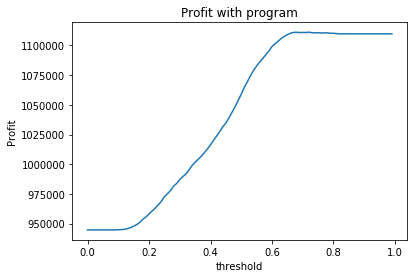

In [106]:
fig = plt.figure()
plt.plot(threshold_vals, [-threshold_optimization(threshold) for threshold in threshold_vals])
plt.title('Profit with program')
plt.xlabel("threshold")
plt.ylabel("Profit") 
plt.show()

In [107]:
opt_threshold = sc.optimize.minimize_scalar(fun=threshold_optimization, bounds=(0,1), method='Golden')

In [108]:
profit_program_func(predicted, opt_threshold.x, price_with_discount=80) / profit_base

1.0013155523517752

In [109]:
predicted[predicted.pred_prob>=opt_threshold.x].shape[0] / predicted[predicted.pred_prob<opt_threshold.x].shape[0]

0.027573214591539646

In [110]:
opt_threshold.x

0.7162916362339169

#### 2 экономический эффект 
С использованием вышеописанной математической модели и модели предсказания оттока построенной на прошлой неделе курса лучшим оказался результат при пороге примерно равном 0.716. В данном случае выгодный тариф предлагается топу 2.8% пользователей из нашей выборки и общая прибыль увеличивается примерно на 0.016 %

#### 3 Попробуйте усложнить экономическую модель
Усложним линейную модель следующим образом, что предлагаемые скидка будет прямо пропорциональна вероятности. Но, так как величина скидки разная, вероятность изменения решения мы учтем прямо пропорционально размера скидки. В модели ниже размер скидки 
изменяется от 10 до 40, а вероятность изменения решения от 0.5 до 0.95. Порог значения вероятности оттока, с которого начинается программа скидок подберем также, как в предыдущем случае 

In [111]:
predicted.head()

,pred_prob,true,change_decision
20361,0.518090,-1,0
29402,0.490883,-1,0
16118,0.294322,-1,0
39019,0.328051,-1,0
9706,0.663042,-1,0


In [112]:
def get_coefs(max_disc, min_disc, max_prob, min_prob, threshold):
    try:
        k1 = (max_disc - min_disc) / (1 - threshold)
        c1 = max_disc - k1
        k2 = (max_prob - min_prob) / (1 - threshold)
        c2 = max_prob - k2
        return(k1, c1, k2, c2)
    except ZeroDivisionError:
        return(0, 0, 0, 0)

In [113]:
def new_model_profit_thres(threshold):
    np.random.seed(3)
    k1, c1, k2, c2 = get_coefs(40, 10, 0.95, 0.5, threshold)
    temp_df = predicted
    temp_df['change_decision_prob'] = temp_df['pred_prob'].apply(lambda x: (c2 + k2*x) if x>threshold else 0)
    temp_df['discount'] = temp_df['pred_prob'].apply(lambda x: (c1 + k1*x) if x>threshold else 0)
    temp_df['price'] = temp_df.discount.apply(lambda x: 100 - x)
    temp_df['change_decision'] = temp_df['change_decision_prob'].apply(
                                    lambda x: np.random.choice([0,1], p=[1-x, x]) if x != 0 else 0 )
    model_profit = temp_df[(temp_df.pred_prob<=threshold) & (temp_df.true== -1)].loc[:,'price'].sum() +\
                    temp_df[(temp_df.pred_prob>threshold) & (temp_df.true== -1)].loc[:,'price'].sum() +\
                    temp_df[(temp_df.pred_prob>threshold) & (temp_df.true== 1) & (
                        temp_df.change_decision== 1)].loc[:,'price'].sum()
        
    return(-model_profit)

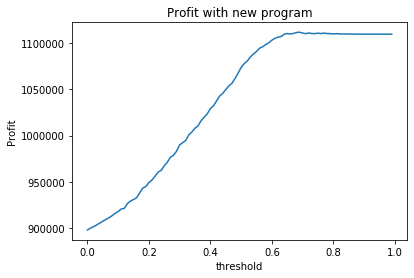

In [132]:
fig = plt.figure()
plt.plot(threshold_vals, [-new_model_profit_thres(threshold) for threshold in threshold_vals])
plt.title('Profit with new program')
plt.xlabel("threshold")
plt.ylabel("Profit") 
plt.savefig('Profit_threshold.jpeg')
plt.show()

In [115]:
opt_threshold = sc.optimize.minimize_scalar(fun=new_model_profit_thres, bounds=(0,1), method='Golden')

In [116]:
print ('New model and base model ratio: {}\nOptimal threshold: {}'.format(-opt_threshold.fun / profit_base, opt_threshold.x))

New model and base model ratio: 1.0017734347789289
Optimal threshold: 0.7130652949390512


Видно, что усложненная модель показывает немного лучшие результаты, чем простая

Попробуем закрепить границу оптимального порога и максимальнрую вероятность принятия решения остаться 0.95 и максимальную скидку равной. Зависимость принятия решения остатья и размер скидки остануться прямо пропорциональными.

In [117]:
def new_model_profit(min_disc):
    np.random.seed(3)
    threshold = opt_threshold.x
    k1, c1, k2, c2 = get_coefs(40, min_disc, 0.95, (0.95 - ((40- min_disc)*0.45/30)), threshold)
    temp_df = predicted
    temp_df['change_decision_prob'] = temp_df['pred_prob'].apply(lambda x: (c2 + k2*x) if x>threshold else 0)
    temp_df['discount'] = temp_df['pred_prob'].apply(lambda x: (c1 + k1*x) if x>threshold else 0)
    temp_df['price'] = temp_df.discount.apply(lambda x: 100 - x)
    temp_df['change_decision'] = temp_df['change_decision_prob'].apply(
                                    lambda x: np.random.choice([0,1], p=[1-x, x]) if x != 0 else 0 )
    model_profit = temp_df[(temp_df.pred_prob<=threshold) & (temp_df.true== -1)].loc[:,'price'].sum() +\
                    temp_df[(temp_df.pred_prob>threshold) & (temp_df.true== -1)].loc[:,'price'].sum() +\
                    temp_df[(temp_df.pred_prob>threshold) & (temp_df.true== 1) & (
                        temp_df.change_decision== 1)].loc[:,'price'].sum()
    return(-model_profit)

In [118]:
min_discount_vals = np.arange(0, 39.5, 0.5)

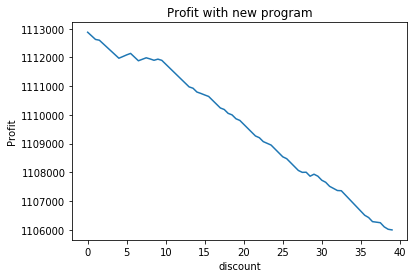

In [119]:
fig = plt.figure()
plt.plot(min_discount_vals, [-new_model_profit(disc) for disc in min_discount_vals])
plt.title('Profit with new program')
plt.xlabel("discount")
plt.ylabel("Profit") 
plt.show()

Выше представлен график при оптимальном пороге из предыдщего опыта. А на этом графике, видно, что минимальный интервал лучше начинать с 0, а не с 10.

#### 4 Всегда ли применение модели экономически оправданно?
Применение модели не всегда экономически оправданно. Если модель плохо определяет пользователей склонных к оттоку или определяет много ошибается на пользователях не склонных к оттоку, то предложение скидки пользователям, с целью их удержать, будет убыточным

#### 5. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели 

Под увеличением качества на 1% и 3% будем понимать, что предсказанная вероятность метки класса сдвинется в сторону реальной метки класса на 1 и 3 % соответсвенно

In [120]:
predicted_original = predicted.copy()

In [121]:
def new_pred_prod(prob, val, qual_inc):
    if val == 1:
        return(prob+qual_inc if prob+qual_inc<1 else 1)
    if val == -1:
        return(prob-qual_inc if prob-qual_inc>0 else 0)

In [122]:
predicted['pred_prob'] = predicted[['pred_prob', 'true']].apply(lambda x: new_pred_prod(x[0], x[1], 0.01), axis=1)

In [123]:
profit_1perc = new_model_profit_thres(opt_threshold.x)

In [124]:
predicted = predicted_original.copy()

In [125]:
predicted['pred_prob'] = predicted[['pred_prob', 'true']].apply(lambda x: new_pred_prod(x[0], x[1], 0.03), axis=1)

In [126]:
profit_3perc  = new_model_profit_thres(opt_threshold.x)

In [127]:
predicted = predicted_original.copy()

In [128]:
profit_original  = new_model_profit_thres(opt_threshold.x)

In [129]:
profit_original, profit_1perc, profit_3perc

(-1111768.1579176553, -1112585.886034785, -1115001.8630843582)

In [130]:
print('1% model improvment increased profit by {:.2f} %\n3% model improvment increased profit by {:.2f} %'.format(
                100*(profit_1perc-profit_original)/profit_original, 100*(profit_3perc-profit_original)/profit_original))

1% model improvment increased profit by 0.07 %
3% model improvment increased profit by 0.29 %


Улучешение на 1 и 3 процента, увеличит общую прибыль на 0.07 и 0.29 процентов соответсвенно, при использовании модели из пункта 3

#### 6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Для начала я бы предложил провести А/Б тестирование для текущей модели, если модель действительно будет значимо увеличивать прибыль, то продолжить улучшать модель. Если нет, то нужно пересмотреть экономическую модель для оценки предсказательной модели.
Улучшение качества модели на 1% принесло увеличение прибыли на 0.07% это значимые деньги для для больших компаний. То есть будет полезно вкладываться в улучшение модели. На сколько нужно улучшить модель - вопрос неоднозначный, чем выше качество - тем лучше. Улучшение качества модели связано с возможным расширением штата сотрудников и сбором дополнительных данных от пользователей. Это тоже стоит каких-то денег. То есть необходимо будет взвешивать предполагаемые затраты на улучшение модели и ее эффект.